<a href="https://colab.research.google.com/github/soundrop199005/colabtest/blob/main/Level2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimise the model to achieve high accuracy with a small model.
The optimised model must contain less than 1 million parameters.
● Expand on the details of the model performance with a confusion matrix
and breakdown accuracy for each label/class
● Measure the inference time of the model in milliseconds per image per
CPU
● Measure the number of p

# Import Library & Data

In [ ]:
#General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import gc
# Keras imports
import keras
import random
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.optimizers import *
from tensorflow.keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
# application (model) imports
from keras import applications
#from keras.applications.inception_v3 import preprocess_input
from keras.layers import Dense
import time
import math

In [29]:
#General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import gc
# Keras imports
import keras
import random
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.optimizers import *
from tensorflow.keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
# application (model) imports
from keras import applications
#from keras.applications.inception_v3 import preprocess_input
from keras.layers import Dense
import time
import math
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# import data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 [==============================] - 10s 0us/step


Below is the Cifa class labelled

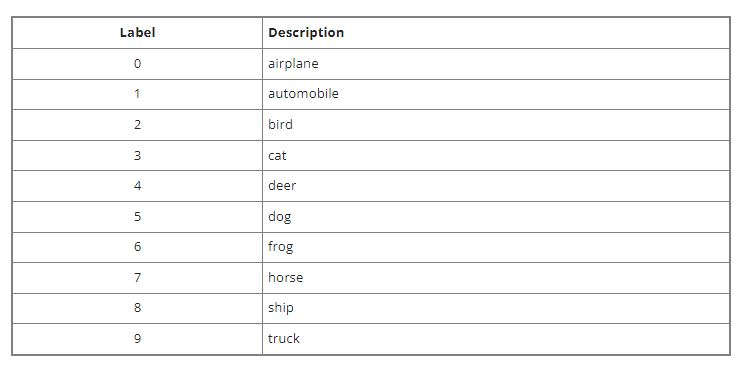

18365
[4]


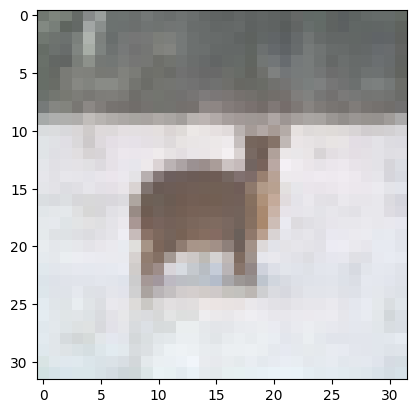

In [ ]:
# sample to have a look

def sample_show(x,y):
  # random generate a number from 0 to length-1
  index_sa = random.randint(0, len(y)-1)
  print(index_sa)
  plt.imshow(x[index_sa])
  print(y[index_sa])

sample_show(x_train, y_train)

7607
[0]


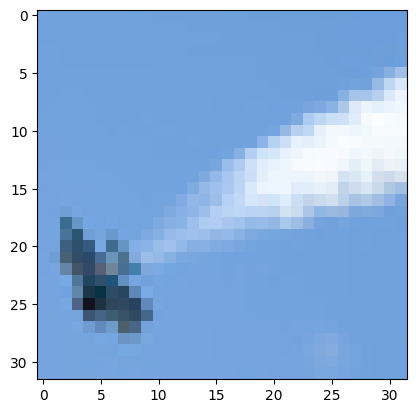

In [ ]:
sample_show(x_test, y_test)

Let's have a look at class imbalance.

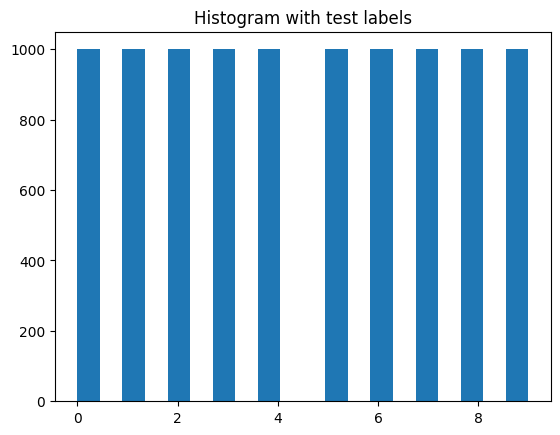

In [ ]:
_ = plt.hist(y_test, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with test labels")
plt.show()

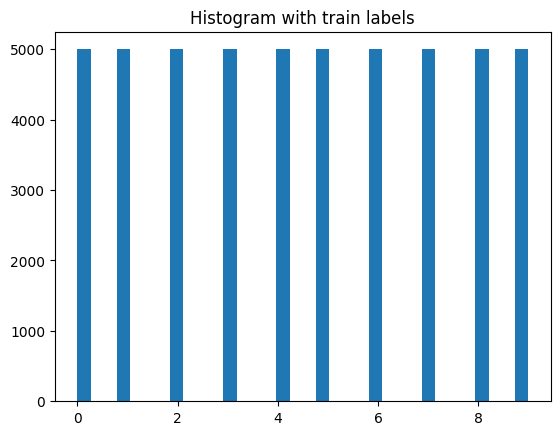

In [ ]:
_ = plt.hist(y_train, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with train labels")
plt.show()

There is not much difference among different classes. Then we can hot encoding the labels and split the validation set from training

In [ ]:
print("First 5 training labels: ", y_train[:5])

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)
print(y_test.shape)

First 5 training labels:  [[6]
 [9]
 [9]
 [4]
 [1]]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(50000, 10)
(10000, 10)


In [ ]:
trainX, valX, trainY, valY = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle = True, stratify=y_train)

In [ ]:
[each.shape for each in [trainX, valX, trainY, valY]]

[(40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 10), (10000, 10)]

# Model Selection and Training

## Base Model Candidates

As discussed in the notes, I am using MobileNet as main base model architecture to train the network. Having a look at the parameter number of each basemodel, I found our training sample size is still quite small compared to those default basemodels if we want to train it from scratch.

In [ ]:
base_model_1= applications.MobileNet(
    input_shape=(32,32,3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling=None,
    classes=10,
    classifier_activation="softmax"
)
base_model_1.summary()

Model: "mobilenet_1.00_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 16, 16, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 16, 16, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 16, 16, 32)  

The image size quickly drops to 1 by 1 which makes those deeper layers redundant. I can potentially remove some depth wise, point wise convolution layers. Let's have a look at other networks which have the similar issues.

In [ ]:
base_model_2 = applications.MobileNetV2(
    input_shape=(32,32,3),
    alpha=1.0,
    include_top=True,
    weights= None,
    input_tensor=None,
    pooling=None,
    classes=10,
    classifier_activation="softmax"
)
base_model_2.summary()

Model: "mobilenetv2_1.00_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[0

When it comes to block_12_add (Add), we can stop it since it is 2*2*96 already. We do not want the dimensions further reduced untill last few layers. Then we can add convolution layers followed by batchnormalization and relu, global average pooling layers, predictions as the last few layers.

In [ ]:
base_model_3 = applications.MobileNetV3Small(
    input_shape=(32,32,3),
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights=None,
    input_tensor=None,
    classes=10,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
)
base_model_3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_3[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 16, 16, 16)           432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 16, 16, 16)           64        ['Conv[0][0]']                
 lization)                                                                         

In [ ]:
gc.collect()

3577

## Build Model

In [ ]:
print("Number of layers in the base model MobileNetV2: ", len(base_model_2.layers))

Number of layers in the base model MobileNetV2:  156


In [ ]:
base_model_2.layers

In [ ]:
base_model_2.layers[115].output

<KerasTensor: shape=(None, 2, 2, 96) dtype=float32 (created by layer 'block_12_add')>

In [ ]:
base_model_2.layers[151:]

In [ ]:
# data augmentation to increase the sample size
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  ])

In [ ]:
# get preprocess to scale input pixels between -1 and 1
preprocess_input = applications.mobilenet_v2.preprocess_input

In [ ]:
# x = data_augmentation(inputs)
inputs = tf.keras.Input(shape=(32, 32, 3))
x = preprocess_input(inputs)
feature_extractor = keras.Model(base_model_2.input, base_model_2.layers[115].output)
x_h = feature_extractor(x, training=True)

x_c = keras.layers.Conv2D(filters = 1280, kernel_size = 1, input_shape = x_h.shape[1:])(x_h)
x_b = tf.keras.layers.BatchNormalization()(x_c)
x_r = tf.keras.layers.ReLU()(x_b)
x_a = tf.keras.layers.GlobalAveragePooling2D()(x_r)
x_d = tf.keras.layers.Dropout(0.2)(x_a)
outputs = tf.keras.layers.Dense(10,activation='softmax')(x_d)
model = tf.keras.Model(inputs, outputs)
alpha = 0.0001  # weight decay coefficient
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))
model.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_23 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 tf.math.subtract_23 (TFOpL  (None, 32, 32, 3)         0         
 ambda)                                                          
                                                                 
 model_29 (Functional)       (None, 2, 2, 96)          558656    
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 2, 1280)        124160    
                                                                 
 batch_normalization_9 (Bat  (None, 2, 2, 1280)        512

In [ ]:
# Let's define a function to construct new_model for hyper parameter tuning later. I want hyperparameter
# tuning the fully connected layer units - original 1280. Also the dropout rate of them. Finally it is
# is important to tune the weight decay rate.
def new_model(alp,fc_units,fc_dropout,weight_decay) -> keras.Sequential:
  inputs = keras.Input(shape=(32, 32, 3))
  preprocess_input = applications.mobilenet_v2.preprocess_input
  x = preprocess_input(inputs)
  base_model_2 = applications.MobileNetV2(
  input_shape=(32,32,3),
  alpha=alp,
  include_top=True,
  weights= None,
  input_tensor=None,
  pooling=None,
  classes=10,
  classifier_activation="softmax")
  feature_extractor = keras.Model(base_model_2.input, base_model_2.layers[115].output)
  x_h = feature_extractor(x, training=True)
  x_c = keras.layers.Conv2D(filters = fc_units, kernel_size = 1, input_shape = x_h.shape[1:])(x_h)
  x_b = tf.keras.layers.BatchNormalization()(x_c)
  x_r = tf.keras.layers.ReLU()(x_b)
  x_a = tf.keras.layers.GlobalAveragePooling2D()(x_r)
  x_d = tf.keras.layers.Dropout(fc_dropout)(x_a)
  outputs = tf.keras.layers.Dense(10,activation='softmax')(x_d)
  model = tf.keras.Model(inputs, outputs)
  alpha = weight_decay  # weight decay coefficient
  for layer in model.layers:
      if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
          layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
      if hasattr(layer, 'bias_regularizer') and layer.use_bias:
          layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))
  print(model.summary())

  return model


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 32, 32, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 32, 32, 3)         0         
 da)                                                             
                                                                 
 model (Functional)          (None, 2, 2, 88)          469056    
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 500)         44500     
                                                                 
 batch_normalization (Batch  (None, 2, 2, 500)         2000

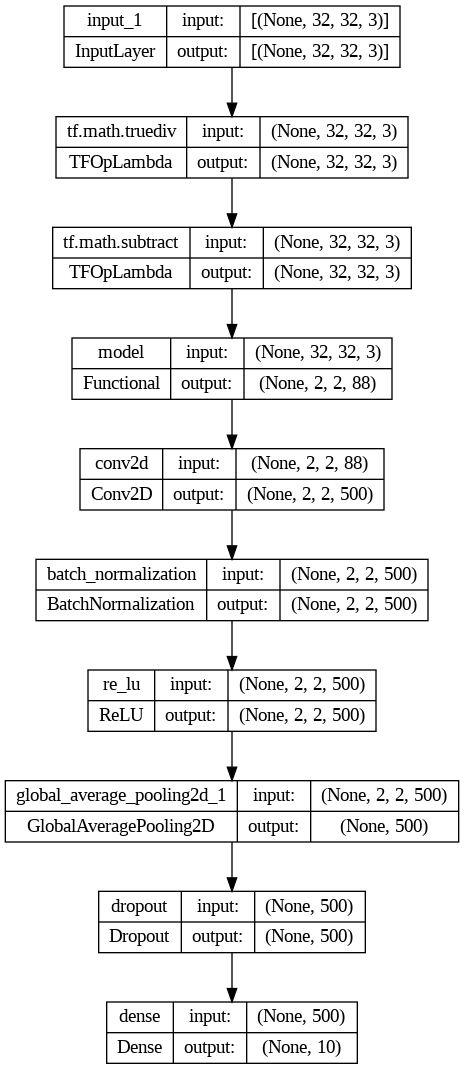

In [ ]:
# create some customized models
m_500_01_000004 = new_model(0.9,500,0.1,0.00004)
tf.keras.utils.plot_model(m_500_01_000004, show_shapes=True)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 32, 32, 3)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 model_2 (Functional)        (None, 2, 2, 80)          368752    
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 1280)        103680    
                                                                 
 batch_normalization_1 (Bat  (None, 2, 2, 1280)        5120

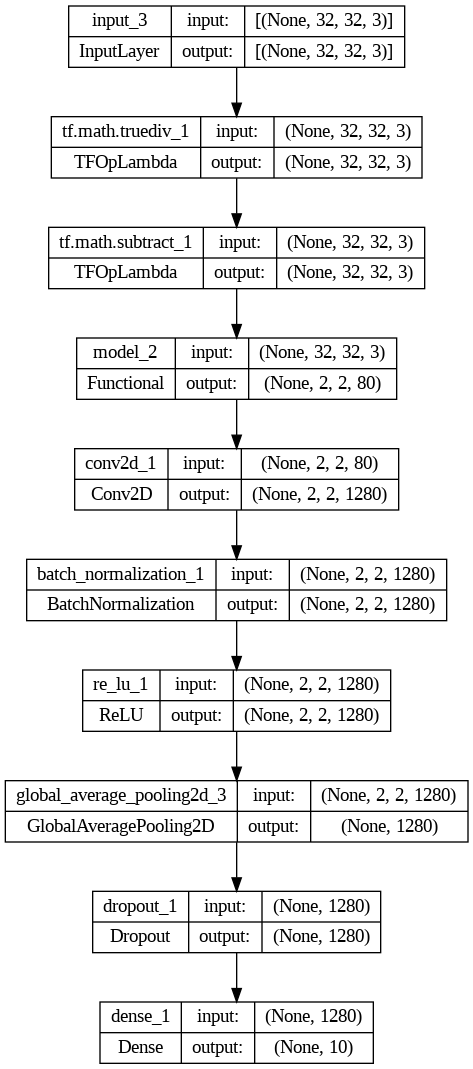

In [ ]:
# another one which is closer to the original architecture
m_1280_02_000004 = new_model(0.8,1280,0.2,0.00004)
tf.keras.utils.plot_model(m_1280_02_000004, show_shapes=True)

## Hyper Para Tuning

Let's grid search for the best alpha, also further decay the learning rate with early stoppings. I add the L2 norm to the model to avoid overfitting.

In [ ]:
def plot_loss_accuracy_s(history,filename):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = min(history.history['val_loss'])
    mylist1 = history.history['val_loss']
    ind = mylist1.index(min(mylist1))
    acc =history.history['val_accuracy'][ind]
    plt.title('Val Loss: %.3f, Val Accuracy: %.3f' % (loss, acc))
    plt.savefig(filename)

Wrap up a function for hyper parameter tuning more easily

In [ ]:
def hyp_tuning(alp, lr, m, wd,fc_u,fc_d):
  # construct model
  model = new_model(alp,fc_u,fc_d,wd)
  # learning rate schedule
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=50,
    decay_rate=0.98)
  # optimizer
  opt = tf.keras.optimizers.experimental.RMSprop(
      learning_rate=lr_schedule,
      rho=0.9,
      momentum=m,
      epsilon=1e-07,
      centered=False,
      # we used weight decay in the model by L2 norm instead
      weight_decay=0,
      clipnorm=None,
      clipvalue=None,
      global_clipnorm=None,
      use_ema=False,
      ema_momentum=0.99,
      ema_overwrite_frequency=100,
      jit_compile=True,
      name='RMSprop'
  )
  parent_dir = '/content/drive/MyDrive/NarrativeTest_SharonXia/new_modelV2_alpha_%.3f_lr_%.9f_m_%.2f_wd_%.7f_fcu_%.1f_fcd_%.2f'%(alp,lr,m,wd,fc_u,fc_d)
  # os.mkdir(parent_dir)
  if not os.path.exists(parent_dir):
    os.mkdir(parent_dir)
  checkpoint_path = os.path.join(parent_dir, 'model.h5')
  print(checkpoint_path)
  my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')]
  # compile model
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  # fit model
  history = model.fit(trainX, trainY, validation_data=(valX,valY), epochs=50, verbose=True, batch_size=64, shuffle=True,callbacks= my_callbacks)
  plot_loss_accuracy_s(history,parent_dir+'.png')
  return min(history.history['val_loss'])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 32, 32, 3)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 model_6 (Functional)        (None, 2, 2, 64)          296016    
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 1280)        83200     
                                                                 
 batch_normalization_3 (Bat  (None, 2, 2, 1280)        5120

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 41s 21ms/step - loss: 1.9327 - accuracy: 0.2829 - val_loss: 1.6095 - val_accuracy: 0.4026
Epoch 2/50
625/625 [==============================] - 12s 19ms/step - loss: 1.5258 - accuracy: 0.4434 - val_loss: 1.4386 - val_accuracy: 0.4762
Epoch 3/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3598 - accuracy: 0.5073 - val_loss: 1.3468 - val_accuracy: 0.5100
Epoch 4/50
625/625 [==============================] - 12s 20ms/step - loss: 1.2443 - accuracy: 0.5477 - val_loss: 1.3269 - val_accuracy: 0.5239
Epoch 5/50
625/625 [==============================] - 12s 19ms/step - loss: 1.1570 - accuracy: 0.5819 - val_loss: 1.2975 - val_accuracy: 0.5346
Epoch 6/50
625/625 [==============================] - 12s 18ms/step - loss: 1.0828 - accuracy: 0.6090 - val_loss: 1.3077 - val_accuracy: 0.5453
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.0264 - accuracy: 0.6299 - val_loss: 1.3163 - val_accuracy: 0.5423
Epo

1.29752779006958

<Figure size 800x600 with 0 Axes>

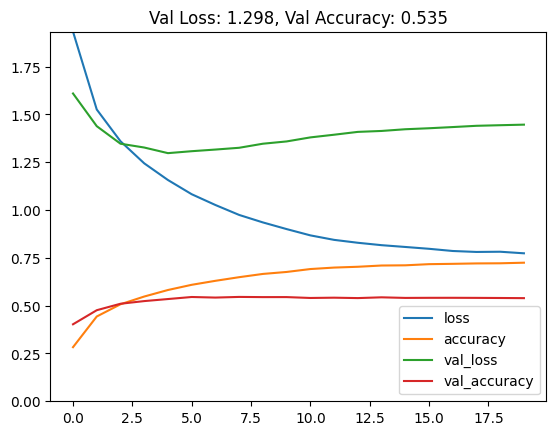

In [ ]:
hyp_tuning(alp = 0.7 ,lr = 0.00005,m = 0.9,wd = 0.00001,fc_u = 1280,fc_d = 0.2)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_5 (TFOpLam  (None, 32, 32, 3)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_5 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 model_10 (Functional)       (None, 2, 2, 80)          368752    
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 500)         40500     
                                                                 
 batch_normalization_5 (Bat  (None, 2, 2, 500)         200

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 20ms/step - loss: 2.1254 - accuracy: 0.2174 - val_loss: 1.7692 - val_accuracy: 0.3357
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.7472 - accuracy: 0.3501 - val_loss: 1.6243 - val_accuracy: 0.3903
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.6047 - accuracy: 0.4040 - val_loss: 1.5610 - val_accuracy: 0.4214
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5040 - accuracy: 0.4469 - val_loss: 1.5367 - val_accuracy: 0.4347
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.4398 - accuracy: 0.4747 - val_loss: 1.5291 - val_accuracy: 0.4388
Epoch 6/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3893 - accuracy: 0.4923 - val_loss: 1.5162 - val_accuracy: 0.4471
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3459 - accuracy: 0.5113 - val_loss: 1.5211 - val_accuracy: 0.4510
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 2.0836 - accuracy: 0.2237 - val_loss: 1.7918 - val_accuracy: 0.3305
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.7014 - accuracy: 0.3624 - val_loss: 1.5942 - val_accuracy: 0.4074
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.5302 - accuracy: 0.4349 - val_loss: 1.5129 - val_accuracy: 0.4493
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4345 - accuracy: 0.4757 - val_loss: 1.4718 - val_accuracy: 0.4642
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3618 - accuracy: 0.5053 - val_loss: 1.4537 - val_accuracy: 0.4722
Epoch 6/50
625/625 [==============================] - 12s 18ms/step - loss: 1.3030 - accuracy: 0.5261 - val_loss: 1.4593 - val_accuracy: 0.4771
Epoch 7/50
625/625 [==============================] - 13s 20ms/step - loss: 1.2572 - accuracy: 0.5457 - val_loss: 1.4505 - val_accuracy: 0.4819
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 2.1380 - accuracy: 0.2162 - val_loss: 1.7736 - val_accuracy: 0.3350
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.7344 - accuracy: 0.3568 - val_loss: 1.5987 - val_accuracy: 0.4052
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5778 - accuracy: 0.4175 - val_loss: 1.5268 - val_accuracy: 0.4420
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.4729 - accuracy: 0.4618 - val_loss: 1.4944 - val_accuracy: 0.4522
Epoch 5/50
625/625 [==============================] - 12s 19ms/step - loss: 1.4034 - accuracy: 0.4897 - val_loss: 1.4796 - val_accuracy: 0.4690
Epoch 6/50
625/625 [==============================] - 11s 18ms/step - loss: 1.3430 - accuracy: 0.5143 - val_loss: 1.4814 - val_accuracy: 0.4683
Epoch 7/50
625/625 [==============================] - 12s 18ms/step - loss: 1.2997 - accuracy: 0.5283 - val_loss: 1.4830 - val_accuracy: 0.4672
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 2.0648 - accuracy: 0.2359 - val_loss: 1.8201 - val_accuracy: 0.3144
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.7182 - accuracy: 0.3601 - val_loss: 1.6491 - val_accuracy: 0.3882
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5597 - accuracy: 0.4216 - val_loss: 1.5665 - val_accuracy: 0.4236
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.4555 - accuracy: 0.4651 - val_loss: 1.5175 - val_accuracy: 0.4431
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3751 - accuracy: 0.4978 - val_loss: 1.5080 - val_accuracy: 0.4531
Epoch 6/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3156 - accuracy: 0.5179 - val_loss: 1.5012 - val_accuracy: 0.4575
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2627 - accuracy: 0.5425 - val_loss: 1.5066 - val_accuracy: 0.4601
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 20ms/step - loss: 2.1414 - accuracy: 0.2160 - val_loss: 1.8033 - val_accuracy: 0.3256
Epoch 2/50
625/625 [==============================] - 12s 19ms/step - loss: 1.7652 - accuracy: 0.3462 - val_loss: 1.6244 - val_accuracy: 0.3973
Epoch 3/50
625/625 [==============================] - 12s 20ms/step - loss: 1.5924 - accuracy: 0.4119 - val_loss: 1.5561 - val_accuracy: 0.4279
Epoch 4/50
625/625 [==============================] - 12s 19ms/step - loss: 1.4945 - accuracy: 0.4489 - val_loss: 1.5338 - val_accuracy: 0.4425
Epoch 5/50
625/625 [==============================] - 12s 19ms/step - loss: 1.4137 - accuracy: 0.4841 - val_loss: 1.5116 - val_accuracy: 0.4523
Epoch 6/50
625/625 [==============================] - 12s 20ms/step - loss: 1.3607 - accuracy: 0.5015 - val_loss: 1.5045 - val_accuracy: 0.4586
Epoch 7/50
625/625 [==============================] - 11s 18ms/step - loss: 1.3129 - accuracy: 0.5203 - val_loss: 1.5056 - val_accuracy: 0.4602
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 20ms/step - loss: 2.1052 - accuracy: 0.2225 - val_loss: 1.8170 - val_accuracy: 0.3276
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.7335 - accuracy: 0.3610 - val_loss: 1.6326 - val_accuracy: 0.3986
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.5749 - accuracy: 0.4235 - val_loss: 1.5470 - val_accuracy: 0.4329
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4750 - accuracy: 0.4620 - val_loss: 1.5087 - val_accuracy: 0.4474
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4025 - accuracy: 0.4908 - val_loss: 1.4904 - val_accuracy: 0.4625
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3469 - accuracy: 0.5089 - val_loss: 1.4850 - val_accuracy: 0.4670
Epoch 7/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3072 - accuracy: 0.5283 - val_loss: 1.4806 - val_accuracy: 0.4668
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 2.1011 - accuracy: 0.2236 - val_loss: 1.7586 - val_accuracy: 0.3383
Epoch 2/50
625/625 [==============================] - 12s 19ms/step - loss: 1.7323 - accuracy: 0.3480 - val_loss: 1.6219 - val_accuracy: 0.3957
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.5905 - accuracy: 0.4047 - val_loss: 1.5546 - val_accuracy: 0.4293
Epoch 4/50
625/625 [==============================] - 12s 19ms/step - loss: 1.4918 - accuracy: 0.4488 - val_loss: 1.5258 - val_accuracy: 0.4427
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4286 - accuracy: 0.4749 - val_loss: 1.5070 - val_accuracy: 0.4504
Epoch 6/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3814 - accuracy: 0.4954 - val_loss: 1.5040 - val_accuracy: 0.4551
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3327 - accuracy: 0.5151 - val_loss: 1.5071 - val_accuracy: 0.4568
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 21ms/step - loss: 2.0447 - accuracy: 0.2424 - val_loss: 1.7893 - val_accuracy: 0.3363
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.7158 - accuracy: 0.3647 - val_loss: 1.6402 - val_accuracy: 0.3833
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5711 - accuracy: 0.4223 - val_loss: 1.5710 - val_accuracy: 0.4234
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4722 - accuracy: 0.4583 - val_loss: 1.5431 - val_accuracy: 0.4351
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4005 - accuracy: 0.4885 - val_loss: 1.5352 - val_accuracy: 0.4438
Epoch 6/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3481 - accuracy: 0.5109 - val_loss: 1.5289 - val_accuracy: 0.4475
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3112 - accuracy: 0.5234 - val_loss: 1.5341 - val_accuracy: 0.4479
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 22ms/step - loss: 2.1128 - accuracy: 0.2176 - val_loss: 1.7762 - val_accuracy: 0.3310
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7330 - accuracy: 0.3541 - val_loss: 1.6043 - val_accuracy: 0.4014
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5742 - accuracy: 0.4194 - val_loss: 1.5387 - val_accuracy: 0.4360
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.4756 - accuracy: 0.4583 - val_loss: 1.5129 - val_accuracy: 0.4503
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4013 - accuracy: 0.4911 - val_loss: 1.4912 - val_accuracy: 0.4588
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3507 - accuracy: 0.5062 - val_loss: 1.4829 - val_accuracy: 0.4656
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3096 - accuracy: 0.5251 - val_loss: 1.4884 - val_accuracy: 0.4706
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 21ms/step - loss: 2.0392 - accuracy: 0.2415 - val_loss: 1.7654 - val_accuracy: 0.3405
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6952 - accuracy: 0.3686 - val_loss: 1.6111 - val_accuracy: 0.4021
Epoch 3/50
625/625 [==============================] - 13s 22ms/step - loss: 1.5394 - accuracy: 0.4330 - val_loss: 1.5548 - val_accuracy: 0.4353
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.4437 - accuracy: 0.4718 - val_loss: 1.5108 - val_accuracy: 0.4542
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3647 - accuracy: 0.5044 - val_loss: 1.4970 - val_accuracy: 0.4606
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3118 - accuracy: 0.5229 - val_loss: 1.4948 - val_accuracy: 0.4630
Epoch 7/50
625/625 [==============================] - 12s 20ms/step - loss: 1.2642 - accuracy: 0.5402 - val_loss: 1.5008 - val_accuracy: 0.4670
Epo

<ipython-input-11-8f315e5bd7f0>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_16 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 tf.math.subtract_16 (TFOpL  (None, 32, 32, 3)         0         
 ambda)                                                          
                                                                 
 model_32 (Functional)       (None, 2, 2, 80)          368752    
                                                                 
 conv2d_16 (Conv2D)          (None, 2, 2, 2000)        162000    
                                                                 
 batch_normalization_16 (Ba  (None, 2, 2, 2000)        800

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 2.1448 - accuracy: 0.2197 - val_loss: 1.7908 - val_accuracy: 0.3244
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.7547 - accuracy: 0.3478 - val_loss: 1.6150 - val_accuracy: 0.3980
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5883 - accuracy: 0.4103 - val_loss: 1.5436 - val_accuracy: 0.4256
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4842 - accuracy: 0.4542 - val_loss: 1.5037 - val_accuracy: 0.4469
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.4017 - accuracy: 0.4865 - val_loss: 1.4804 - val_accuracy: 0.4600
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3448 - accuracy: 0.5084 - val_loss: 1.4837 - val_accuracy: 0.4611
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2985 - accuracy: 0.5273 - val_loss: 1.4806 - val_accuracy: 0.4663
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 1.7272 - accuracy: 0.3616 - val_loss: 1.4329 - val_accuracy: 0.4805
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3063 - accuracy: 0.5285 - val_loss: 1.2476 - val_accuracy: 0.5552
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.1212 - accuracy: 0.5956 - val_loss: 1.1452 - val_accuracy: 0.5913
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 0.9925 - accuracy: 0.6444 - val_loss: 1.0927 - val_accuracy: 0.6170
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 0.8855 - accuracy: 0.6852 - val_loss: 1.0783 - val_accuracy: 0.6268
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7969 - accuracy: 0.7178 - val_loss: 1.0796 - val_accuracy: 0.6338
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7225 - accuracy: 0.7446 - val_loss: 1.1034 - val_accuracy: 0.6360
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 20ms/step - loss: 1.7640 - accuracy: 0.3486 - val_loss: 1.4291 - val_accuracy: 0.4757
Epoch 2/50
625/625 [==============================] - 12s 20ms/step - loss: 1.3561 - accuracy: 0.5086 - val_loss: 1.2406 - val_accuracy: 0.5537
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.1652 - accuracy: 0.5839 - val_loss: 1.1472 - val_accuracy: 0.5911
Epoch 4/50
625/625 [==============================] - 12s 19ms/step - loss: 1.0389 - accuracy: 0.6306 - val_loss: 1.1075 - val_accuracy: 0.6072
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 0.9279 - accuracy: 0.6709 - val_loss: 1.0987 - val_accuracy: 0.6132
Epoch 6/50
625/625 [==============================] - 11s 18ms/step - loss: 0.8451 - accuracy: 0.7000 - val_loss: 1.1087 - val_accuracy: 0.6241
Epoch 7/50
625/625 [==============================] - 11s 18ms/step - loss: 0.7694 - accuracy: 0.7278 - val_loss: 1.1343 - val_accuracy: 0.6220
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 20ms/step - loss: 1.7590 - accuracy: 0.3510 - val_loss: 1.5176 - val_accuracy: 0.4326
Epoch 2/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3518 - accuracy: 0.5094 - val_loss: 1.2794 - val_accuracy: 0.5388
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.1549 - accuracy: 0.5859 - val_loss: 1.1638 - val_accuracy: 0.5865
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.0249 - accuracy: 0.6311 - val_loss: 1.0993 - val_accuracy: 0.6157
Epoch 5/50
625/625 [==============================] - 12s 20ms/step - loss: 0.9205 - accuracy: 0.6706 - val_loss: 1.0815 - val_accuracy: 0.6183
Epoch 6/50
625/625 [==============================] - 11s 18ms/step - loss: 0.8365 - accuracy: 0.7038 - val_loss: 1.0959 - val_accuracy: 0.6210
Epoch 7/50
625/625 [==============================] - 11s 18ms/step - loss: 0.7612 - accuracy: 0.7286 - val_loss: 1.1150 - val_accuracy: 0.6243
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 20ms/step - loss: 1.7807 - accuracy: 0.3492 - val_loss: 1.4348 - val_accuracy: 0.4719
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3522 - accuracy: 0.5105 - val_loss: 1.2475 - val_accuracy: 0.5534
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.1568 - accuracy: 0.5870 - val_loss: 1.1545 - val_accuracy: 0.5953
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.0247 - accuracy: 0.6345 - val_loss: 1.0990 - val_accuracy: 0.6122
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 0.9167 - accuracy: 0.6743 - val_loss: 1.0658 - val_accuracy: 0.6281
Epoch 6/50
625/625 [==============================] - 12s 18ms/step - loss: 0.8318 - accuracy: 0.7045 - val_loss: 1.0830 - val_accuracy: 0.6272
Epoch 7/50
625/625 [==============================] - 12s 18ms/step - loss: 0.7522 - accuracy: 0.7317 - val_loss: 1.1026 - val_accuracy: 0.6305
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 20ms/step - loss: 1.7388 - accuracy: 0.3669 - val_loss: 1.5010 - val_accuracy: 0.4760
Epoch 2/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3392 - accuracy: 0.5182 - val_loss: 1.2503 - val_accuracy: 0.5536
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.1582 - accuracy: 0.5860 - val_loss: 1.1890 - val_accuracy: 0.5822
Epoch 4/50
625/625 [==============================] - 12s 20ms/step - loss: 1.0304 - accuracy: 0.6323 - val_loss: 1.1151 - val_accuracy: 0.6100
Epoch 5/50
625/625 [==============================] - 12s 20ms/step - loss: 0.9249 - accuracy: 0.6685 - val_loss: 1.0911 - val_accuracy: 0.6157
Epoch 6/50
625/625 [==============================] - 13s 20ms/step - loss: 0.8338 - accuracy: 0.7027 - val_loss: 1.0903 - val_accuracy: 0.6208
Epoch 7/50
625/625 [==============================] - 12s 18ms/step - loss: 0.7579 - accuracy: 0.7298 - val_loss: 1.1027 - val_accuracy: 0.6241
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 1.8056 - accuracy: 0.3525 - val_loss: 1.4568 - val_accuracy: 0.4789
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3314 - accuracy: 0.5243 - val_loss: 1.2561 - val_accuracy: 0.5609
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.1371 - accuracy: 0.5974 - val_loss: 1.1209 - val_accuracy: 0.6065
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.0046 - accuracy: 0.6434 - val_loss: 1.0802 - val_accuracy: 0.6274
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 0.9033 - accuracy: 0.6813 - val_loss: 1.0651 - val_accuracy: 0.6379
Epoch 6/50
625/625 [==============================] - 13s 20ms/step - loss: 0.8168 - accuracy: 0.7123 - val_loss: 1.0420 - val_accuracy: 0.6455
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7395 - accuracy: 0.7398 - val_loss: 1.0623 - val_accuracy: 0.6439
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 21ms/step - loss: 1.7236 - accuracy: 0.3642 - val_loss: 1.4323 - val_accuracy: 0.4828
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3198 - accuracy: 0.5231 - val_loss: 1.2528 - val_accuracy: 0.5569
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.1313 - accuracy: 0.5955 - val_loss: 1.1461 - val_accuracy: 0.5943
Epoch 4/50
625/625 [==============================] - 12s 20ms/step - loss: 1.0077 - accuracy: 0.6411 - val_loss: 1.0903 - val_accuracy: 0.6220
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 0.9053 - accuracy: 0.6786 - val_loss: 1.0672 - val_accuracy: 0.6269
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.8146 - accuracy: 0.7112 - val_loss: 1.0704 - val_accuracy: 0.6326
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7428 - accuracy: 0.7369 - val_loss: 1.0969 - val_accuracy: 0.6357
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 20ms/step - loss: 1.7644 - accuracy: 0.3565 - val_loss: 1.4550 - val_accuracy: 0.4629
Epoch 2/50
625/625 [==============================] - 12s 20ms/step - loss: 1.3327 - accuracy: 0.5205 - val_loss: 1.2314 - val_accuracy: 0.5607
Epoch 3/50
625/625 [==============================] - 12s 19ms/step - loss: 1.1336 - accuracy: 0.5972 - val_loss: 1.1329 - val_accuracy: 0.6003
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.0026 - accuracy: 0.6468 - val_loss: 1.0999 - val_accuracy: 0.6119
Epoch 5/50
625/625 [==============================] - 12s 19ms/step - loss: 0.8974 - accuracy: 0.6845 - val_loss: 1.0735 - val_accuracy: 0.6272
Epoch 6/50
625/625 [==============================] - 11s 18ms/step - loss: 0.8110 - accuracy: 0.7135 - val_loss: 1.0812 - val_accuracy: 0.6343
Epoch 7/50
625/625 [==============================] - 11s 18ms/step - loss: 0.7428 - accuracy: 0.7392 - val_loss: 1.0974 - val_accuracy: 0.6376
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 20ms/step - loss: 1.7242 - accuracy: 0.3660 - val_loss: 1.4386 - val_accuracy: 0.4835
Epoch 2/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3025 - accuracy: 0.5336 - val_loss: 1.2006 - val_accuracy: 0.5715
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.1114 - accuracy: 0.6052 - val_loss: 1.1108 - val_accuracy: 0.6048
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9778 - accuracy: 0.6521 - val_loss: 1.0642 - val_accuracy: 0.6272
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 0.8666 - accuracy: 0.6923 - val_loss: 1.0558 - val_accuracy: 0.6379
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7799 - accuracy: 0.7243 - val_loss: 1.0564 - val_accuracy: 0.6391
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7016 - accuracy: 0.7494 - val_loss: 1.0895 - val_accuracy: 0.6395
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 21ms/step - loss: 1.7803 - accuracy: 0.3525 - val_loss: 1.4643 - val_accuracy: 0.4697
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3568 - accuracy: 0.5139 - val_loss: 1.2630 - val_accuracy: 0.5495
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.1689 - accuracy: 0.5843 - val_loss: 1.1877 - val_accuracy: 0.5791
Epoch 4/50
625/625 [==============================] - 14s 22ms/step - loss: 1.0339 - accuracy: 0.6320 - val_loss: 1.1120 - val_accuracy: 0.6138
Epoch 5/50
625/625 [==============================] - 13s 22ms/step - loss: 0.9293 - accuracy: 0.6716 - val_loss: 1.0866 - val_accuracy: 0.6248
Epoch 6/50
625/625 [==============================] - 13s 20ms/step - loss: 0.8475 - accuracy: 0.7017 - val_loss: 1.0894 - val_accuracy: 0.6272
Epoch 7/50
625/625 [==============================] - 12s 20ms/step - loss: 0.7691 - accuracy: 0.7290 - val_loss: 1.1214 - val_accuracy: 0.6253
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 22ms/step - loss: 1.7835 - accuracy: 0.3509 - val_loss: 1.5117 - val_accuracy: 0.4612
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3702 - accuracy: 0.5070 - val_loss: 1.2920 - val_accuracy: 0.5460
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.1741 - accuracy: 0.5798 - val_loss: 1.1600 - val_accuracy: 0.5872
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.0396 - accuracy: 0.6287 - val_loss: 1.1188 - val_accuracy: 0.6055
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9242 - accuracy: 0.6691 - val_loss: 1.1086 - val_accuracy: 0.6128
Epoch 6/50
625/625 [==============================] - 14s 23ms/step - loss: 0.8310 - accuracy: 0.7050 - val_loss: 1.1053 - val_accuracy: 0.6204
Epoch 7/50
625/625 [==============================] - 12s 20ms/step - loss: 0.7561 - accuracy: 0.7332 - val_loss: 1.1174 - val_accuracy: 0.6278
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 1.8039 - accuracy: 0.3487 - val_loss: 1.7035 - val_accuracy: 0.4231
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3661 - accuracy: 0.5089 - val_loss: 1.2761 - val_accuracy: 0.5483
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.1756 - accuracy: 0.5842 - val_loss: 1.1736 - val_accuracy: 0.5860
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.0377 - accuracy: 0.6334 - val_loss: 1.1264 - val_accuracy: 0.6072
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9383 - accuracy: 0.6687 - val_loss: 1.1057 - val_accuracy: 0.6210
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 0.8427 - accuracy: 0.7010 - val_loss: 1.0956 - val_accuracy: 0.6251
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7683 - accuracy: 0.7292 - val_loss: 1.1386 - val_accuracy: 0.6256
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 2.1784 - accuracy: 0.1893 - val_loss: 1.9404 - val_accuracy: 0.2629
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.8784 - accuracy: 0.2902 - val_loss: 1.7868 - val_accuracy: 0.3286
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.7477 - accuracy: 0.3429 - val_loss: 1.7142 - val_accuracy: 0.3594
Epoch 4/50
625/625 [==============================] - 13s 22ms/step - loss: 1.6669 - accuracy: 0.3760 - val_loss: 1.6737 - val_accuracy: 0.3758
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.6195 - accuracy: 0.3986 - val_loss: 1.6489 - val_accuracy: 0.3856
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5780 - accuracy: 0.4128 - val_loss: 1.6347 - val_accuracy: 0.3959
Epoch 7/50
625/625 [==============================] - 13s 20ms/step - loss: 1.5433 - accuracy: 0.4252 - val_loss: 1.6275 - val_accuracy: 0.3985
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 22ms/step - loss: 2.3240 - accuracy: 0.1543 - val_loss: 2.0378 - val_accuracy: 0.2340
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 2.0240 - accuracy: 0.2410 - val_loss: 1.8562 - val_accuracy: 0.3081
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.8660 - accuracy: 0.3011 - val_loss: 1.7696 - val_accuracy: 0.3366
Epoch 4/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7750 - accuracy: 0.3361 - val_loss: 1.7226 - val_accuracy: 0.3547
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.7162 - accuracy: 0.3606 - val_loss: 1.6903 - val_accuracy: 0.3677
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6720 - accuracy: 0.3789 - val_loss: 1.6714 - val_accuracy: 0.3745
Epoch 7/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6452 - accuracy: 0.3871 - val_loss: 1.6605 - val_accuracy: 0.3751
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 23ms/step - loss: 2.1887 - accuracy: 0.1846 - val_loss: 1.9548 - val_accuracy: 0.2702
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.8965 - accuracy: 0.2903 - val_loss: 1.7935 - val_accuracy: 0.3336
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7592 - accuracy: 0.3457 - val_loss: 1.7292 - val_accuracy: 0.3592
Epoch 4/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6764 - accuracy: 0.3747 - val_loss: 1.6957 - val_accuracy: 0.3756
Epoch 5/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6181 - accuracy: 0.3972 - val_loss: 1.6742 - val_accuracy: 0.3823
Epoch 6/50
625/625 [==============================] - 14s 23ms/step - loss: 1.5801 - accuracy: 0.4126 - val_loss: 1.6655 - val_accuracy: 0.3917
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5481 - accuracy: 0.4263 - val_loss: 1.6588 - val_accuracy: 0.3947
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 32s 23ms/step - loss: 2.3106 - accuracy: 0.1629 - val_loss: 2.0526 - val_accuracy: 0.2313
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 2.0464 - accuracy: 0.2465 - val_loss: 1.8926 - val_accuracy: 0.3041
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.8933 - accuracy: 0.2998 - val_loss: 1.7909 - val_accuracy: 0.3349
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 1.7879 - accuracy: 0.3388 - val_loss: 1.7312 - val_accuracy: 0.3645
Epoch 5/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7230 - accuracy: 0.3639 - val_loss: 1.7007 - val_accuracy: 0.3724
Epoch 6/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6740 - accuracy: 0.3811 - val_loss: 1.6815 - val_accuracy: 0.3818
Epoch 7/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6465 - accuracy: 0.3916 - val_loss: 1.6678 - val_accuracy: 0.3903
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 22ms/step - loss: 2.1776 - accuracy: 0.1983 - val_loss: 1.9810 - val_accuracy: 0.2688
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.9255 - accuracy: 0.2858 - val_loss: 1.8418 - val_accuracy: 0.3125
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7812 - accuracy: 0.3403 - val_loss: 1.7721 - val_accuracy: 0.3392
Epoch 4/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6974 - accuracy: 0.3710 - val_loss: 1.7258 - val_accuracy: 0.3594
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6337 - accuracy: 0.3941 - val_loss: 1.7031 - val_accuracy: 0.3701
Epoch 6/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5917 - accuracy: 0.4092 - val_loss: 1.6875 - val_accuracy: 0.3755
Epoch 7/50
625/625 [==============================] - 14s 23ms/step - loss: 1.5556 - accuracy: 0.4276 - val_loss: 1.6837 - val_accuracy: 0.3829
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 22ms/step - loss: 2.3177 - accuracy: 0.1586 - val_loss: 2.0504 - val_accuracy: 0.2299
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 2.0384 - accuracy: 0.2419 - val_loss: 1.8737 - val_accuracy: 0.2941
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.8740 - accuracy: 0.2997 - val_loss: 1.7860 - val_accuracy: 0.3299
Epoch 4/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7792 - accuracy: 0.3363 - val_loss: 1.7426 - val_accuracy: 0.3493
Epoch 5/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7187 - accuracy: 0.3580 - val_loss: 1.7147 - val_accuracy: 0.3622
Epoch 6/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6677 - accuracy: 0.3753 - val_loss: 1.6996 - val_accuracy: 0.3736
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6395 - accuracy: 0.3903 - val_loss: 1.6909 - val_accuracy: 0.3746
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 32s 23ms/step - loss: 2.2078 - accuracy: 0.1824 - val_loss: 1.9288 - val_accuracy: 0.2764
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.8606 - accuracy: 0.2954 - val_loss: 1.7586 - val_accuracy: 0.3420
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7194 - accuracy: 0.3571 - val_loss: 1.6875 - val_accuracy: 0.3699
Epoch 4/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6396 - accuracy: 0.3862 - val_loss: 1.6479 - val_accuracy: 0.3859
Epoch 5/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5887 - accuracy: 0.4096 - val_loss: 1.6258 - val_accuracy: 0.3939
Epoch 6/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5497 - accuracy: 0.4256 - val_loss: 1.6140 - val_accuracy: 0.3984
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5195 - accuracy: 0.4366 - val_loss: 1.6057 - val_accuracy: 0.4039
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 23ms/step - loss: 2.2774 - accuracy: 0.1755 - val_loss: 1.9499 - val_accuracy: 0.2637
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.9491 - accuracy: 0.2670 - val_loss: 1.7897 - val_accuracy: 0.3255
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.8125 - accuracy: 0.3164 - val_loss: 1.7191 - val_accuracy: 0.3529
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 1.7311 - accuracy: 0.3515 - val_loss: 1.6831 - val_accuracy: 0.3733
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6719 - accuracy: 0.3760 - val_loss: 1.6609 - val_accuracy: 0.3862
Epoch 6/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6378 - accuracy: 0.3869 - val_loss: 1.6492 - val_accuracy: 0.3902
Epoch 7/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6070 - accuracy: 0.4032 - val_loss: 1.6389 - val_accuracy: 0.3936
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 32s 24ms/step - loss: 2.2050 - accuracy: 0.1792 - val_loss: 1.9869 - val_accuracy: 0.2580
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.9228 - accuracy: 0.2802 - val_loss: 1.8152 - val_accuracy: 0.3220
Epoch 3/50
625/625 [==============================] - 15s 23ms/step - loss: 1.7808 - accuracy: 0.3383 - val_loss: 1.7370 - val_accuracy: 0.3566
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6990 - accuracy: 0.3688 - val_loss: 1.7012 - val_accuracy: 0.3716
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6446 - accuracy: 0.3911 - val_loss: 1.6852 - val_accuracy: 0.3823
Epoch 6/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6068 - accuracy: 0.4049 - val_loss: 1.6713 - val_accuracy: 0.3875
Epoch 7/50
625/625 [==============================] - 14s 23ms/step - loss: 1.5739 - accuracy: 0.4226 - val_loss: 1.6635 - val_accuracy: 0.3900
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 21ms/step - loss: 2.2869 - accuracy: 0.1699 - val_loss: 2.0377 - val_accuracy: 0.2508
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 2.0425 - accuracy: 0.2501 - val_loss: 1.9026 - val_accuracy: 0.3044
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.8974 - accuracy: 0.3034 - val_loss: 1.8090 - val_accuracy: 0.3391
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.7948 - accuracy: 0.3425 - val_loss: 1.7543 - val_accuracy: 0.3602
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.7256 - accuracy: 0.3658 - val_loss: 1.7214 - val_accuracy: 0.3707
Epoch 6/50
625/625 [==============================] - 13s 22ms/step - loss: 1.6802 - accuracy: 0.3851 - val_loss: 1.6979 - val_accuracy: 0.3812
Epoch 7/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6483 - accuracy: 0.3945 - val_loss: 1.6828 - val_accuracy: 0.3860
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 24ms/step - loss: 2.2443 - accuracy: 0.1724 - val_loss: 2.0455 - val_accuracy: 0.2338
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.9727 - accuracy: 0.2676 - val_loss: 1.8654 - val_accuracy: 0.3021
Epoch 3/50
625/625 [==============================] - 15s 23ms/step - loss: 1.8199 - accuracy: 0.3223 - val_loss: 1.7879 - val_accuracy: 0.3315
Epoch 4/50
625/625 [==============================] - 15s 23ms/step - loss: 1.7281 - accuracy: 0.3579 - val_loss: 1.7485 - val_accuracy: 0.3492
Epoch 5/50
625/625 [==============================] - 15s 23ms/step - loss: 1.6683 - accuracy: 0.3807 - val_loss: 1.7279 - val_accuracy: 0.3628
Epoch 6/50
625/625 [==============================] - 15s 23ms/step - loss: 1.6228 - accuracy: 0.3990 - val_loss: 1.7090 - val_accuracy: 0.3696
Epoch 7/50
625/625 [==============================] - 15s 23ms/step - loss: 1.5901 - accuracy: 0.4096 - val_loss: 1.6994 - val_accuracy: 0.3685
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 33s 24ms/step - loss: 2.2967 - accuracy: 0.1660 - val_loss: 2.0133 - val_accuracy: 0.2471
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 2.0235 - accuracy: 0.2555 - val_loss: 1.8664 - val_accuracy: 0.3079
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.8703 - accuracy: 0.3041 - val_loss: 1.7824 - val_accuracy: 0.3344
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 1.7763 - accuracy: 0.3410 - val_loss: 1.7345 - val_accuracy: 0.3514
Epoch 5/50
625/625 [==============================] - 15s 23ms/step - loss: 1.7131 - accuracy: 0.3643 - val_loss: 1.7026 - val_accuracy: 0.3632
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 1.6662 - accuracy: 0.3819 - val_loss: 1.6886 - val_accuracy: 0.3684
Epoch 7/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6288 - accuracy: 0.3958 - val_loss: 1.6758 - val_accuracy: 0.3740
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 23ms/step - loss: 1.8578 - accuracy: 0.3099 - val_loss: 1.5284 - val_accuracy: 0.4243
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.4528 - accuracy: 0.4646 - val_loss: 1.3502 - val_accuracy: 0.5130
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.2815 - accuracy: 0.5354 - val_loss: 1.2814 - val_accuracy: 0.5438
Epoch 4/50
625/625 [==============================] - 15s 23ms/step - loss: 1.1625 - accuracy: 0.5792 - val_loss: 1.2285 - val_accuracy: 0.5616
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.0708 - accuracy: 0.6150 - val_loss: 1.2261 - val_accuracy: 0.5663
Epoch 6/50
625/625 [==============================] - 15s 23ms/step - loss: 0.9950 - accuracy: 0.6428 - val_loss: 1.2260 - val_accuracy: 0.5717
Epoch 7/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9346 - accuracy: 0.6686 - val_loss: 1.2403 - val_accuracy: 0.5754
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 33s 24ms/step - loss: 1.8974 - accuracy: 0.3032 - val_loss: 1.5419 - val_accuracy: 0.4342
Epoch 2/50
625/625 [==============================] - 15s 24ms/step - loss: 1.4654 - accuracy: 0.4653 - val_loss: 1.3573 - val_accuracy: 0.5091
Epoch 3/50
625/625 [==============================] - 15s 23ms/step - loss: 1.2864 - accuracy: 0.5401 - val_loss: 1.2772 - val_accuracy: 0.5353
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 1.1590 - accuracy: 0.5852 - val_loss: 1.2495 - val_accuracy: 0.5528
Epoch 5/50
625/625 [==============================] - 15s 23ms/step - loss: 1.0675 - accuracy: 0.6231 - val_loss: 1.2442 - val_accuracy: 0.5566
Epoch 6/50
625/625 [==============================] - 14s 22ms/step - loss: 0.9920 - accuracy: 0.6479 - val_loss: 1.2586 - val_accuracy: 0.5676
Epoch 7/50
625/625 [==============================] - 13s 22ms/step - loss: 0.9286 - accuracy: 0.6732 - val_loss: 1.2725 - val_accuracy: 0.5666
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 23ms/step - loss: 1.8691 - accuracy: 0.3029 - val_loss: 1.5648 - val_accuracy: 0.4207
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.4847 - accuracy: 0.4553 - val_loss: 1.4016 - val_accuracy: 0.4902
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.3064 - accuracy: 0.5268 - val_loss: 1.3179 - val_accuracy: 0.5264
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1867 - accuracy: 0.5723 - val_loss: 1.2730 - val_accuracy: 0.5484
Epoch 5/50
625/625 [==============================] - 15s 23ms/step - loss: 1.0921 - accuracy: 0.6076 - val_loss: 1.2681 - val_accuracy: 0.5516
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.0155 - accuracy: 0.6342 - val_loss: 1.2735 - val_accuracy: 0.5633
Epoch 7/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9503 - accuracy: 0.6601 - val_loss: 1.2873 - val_accuracy: 0.5599
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 34s 24ms/step - loss: 1.9194 - accuracy: 0.2984 - val_loss: 1.6173 - val_accuracy: 0.3980
Epoch 2/50
625/625 [==============================] - 15s 24ms/step - loss: 1.5202 - accuracy: 0.4461 - val_loss: 1.4280 - val_accuracy: 0.4810
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.3449 - accuracy: 0.5138 - val_loss: 1.3385 - val_accuracy: 0.5206
Epoch 4/50
625/625 [==============================] - 15s 23ms/step - loss: 1.2153 - accuracy: 0.5627 - val_loss: 1.2964 - val_accuracy: 0.5297
Epoch 5/50
625/625 [==============================] - 15s 23ms/step - loss: 1.1239 - accuracy: 0.5966 - val_loss: 1.2848 - val_accuracy: 0.5473
Epoch 6/50
625/625 [==============================] - 15s 23ms/step - loss: 1.0430 - accuracy: 0.6258 - val_loss: 1.2757 - val_accuracy: 0.5478
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 0.9743 - accuracy: 0.6478 - val_loss: 1.3035 - val_accuracy: 0.5520
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 23ms/step - loss: 1.8725 - accuracy: 0.3089 - val_loss: 1.5335 - val_accuracy: 0.4342
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.4634 - accuracy: 0.4658 - val_loss: 1.3822 - val_accuracy: 0.4998
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.2880 - accuracy: 0.5348 - val_loss: 1.3070 - val_accuracy: 0.5263
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1691 - accuracy: 0.5783 - val_loss: 1.2936 - val_accuracy: 0.5433
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.0686 - accuracy: 0.6193 - val_loss: 1.2640 - val_accuracy: 0.5566
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9823 - accuracy: 0.6473 - val_loss: 1.2990 - val_accuracy: 0.5552
Epoch 7/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9198 - accuracy: 0.6731 - val_loss: 1.3040 - val_accuracy: 0.5549
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 34s 24ms/step - loss: 1.9242 - accuracy: 0.2952 - val_loss: 1.6354 - val_accuracy: 0.4052
Epoch 2/50
625/625 [==============================] - 15s 24ms/step - loss: 1.5120 - accuracy: 0.4503 - val_loss: 1.4044 - val_accuracy: 0.4810
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.3372 - accuracy: 0.5179 - val_loss: 1.3140 - val_accuracy: 0.5214
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 1.2080 - accuracy: 0.5672 - val_loss: 1.2922 - val_accuracy: 0.5399
Epoch 5/50
625/625 [==============================] - 15s 24ms/step - loss: 1.1042 - accuracy: 0.6022 - val_loss: 1.2690 - val_accuracy: 0.5498
Epoch 6/50
625/625 [==============================] - 14s 22ms/step - loss: 1.0274 - accuracy: 0.6318 - val_loss: 1.2713 - val_accuracy: 0.5573
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 0.9561 - accuracy: 0.6563 - val_loss: 1.3088 - val_accuracy: 0.5519
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 23ms/step - loss: 1.8894 - accuracy: 0.2993 - val_loss: 1.5834 - val_accuracy: 0.4133
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.4860 - accuracy: 0.4520 - val_loss: 1.4032 - val_accuracy: 0.4806
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.3147 - accuracy: 0.5220 - val_loss: 1.3144 - val_accuracy: 0.5233
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1920 - accuracy: 0.5673 - val_loss: 1.2786 - val_accuracy: 0.5437
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1021 - accuracy: 0.6033 - val_loss: 1.2691 - val_accuracy: 0.5514
Epoch 6/50
625/625 [==============================] - 14s 23ms/step - loss: 1.0194 - accuracy: 0.6338 - val_loss: 1.2662 - val_accuracy: 0.5577
Epoch 7/50
625/625 [==============================] - 13s 22ms/step - loss: 0.9526 - accuracy: 0.6582 - val_loss: 1.2926 - val_accuracy: 0.5579
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 34s 24ms/step - loss: 1.9398 - accuracy: 0.2887 - val_loss: 1.5596 - val_accuracy: 0.4185
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.4988 - accuracy: 0.4503 - val_loss: 1.3910 - val_accuracy: 0.4927
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.3196 - accuracy: 0.5197 - val_loss: 1.2988 - val_accuracy: 0.5299
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1967 - accuracy: 0.5681 - val_loss: 1.2724 - val_accuracy: 0.5495
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1068 - accuracy: 0.6020 - val_loss: 1.2616 - val_accuracy: 0.5543
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.0230 - accuracy: 0.6338 - val_loss: 1.2662 - val_accuracy: 0.5588
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 0.9589 - accuracy: 0.6568 - val_loss: 1.2750 - val_accuracy: 0.5652
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 24ms/step - loss: 1.8438 - accuracy: 0.3206 - val_loss: 1.5440 - val_accuracy: 0.4368
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.4531 - accuracy: 0.4685 - val_loss: 1.3569 - val_accuracy: 0.5015
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.2740 - accuracy: 0.5376 - val_loss: 1.2986 - val_accuracy: 0.5305
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1585 - accuracy: 0.5822 - val_loss: 1.2454 - val_accuracy: 0.5523
Epoch 5/50
625/625 [==============================] - 15s 23ms/step - loss: 1.0558 - accuracy: 0.6219 - val_loss: 1.2441 - val_accuracy: 0.5558
Epoch 6/50
625/625 [==============================] - 13s 22ms/step - loss: 0.9779 - accuracy: 0.6499 - val_loss: 1.2507 - val_accuracy: 0.5602
Epoch 7/50
625/625 [==============================] - 13s 22ms/step - loss: 0.9061 - accuracy: 0.6759 - val_loss: 1.2736 - val_accuracy: 0.5681
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 32s 25ms/step - loss: 1.9211 - accuracy: 0.2950 - val_loss: 1.5659 - val_accuracy: 0.4238
Epoch 2/50
625/625 [==============================] - 15s 23ms/step - loss: 1.4918 - accuracy: 0.4544 - val_loss: 1.4038 - val_accuracy: 0.4924
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.3159 - accuracy: 0.5243 - val_loss: 1.3108 - val_accuracy: 0.5281
Epoch 4/50
625/625 [==============================] - 15s 23ms/step - loss: 1.1859 - accuracy: 0.5712 - val_loss: 1.2760 - val_accuracy: 0.5446
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.0931 - accuracy: 0.6082 - val_loss: 1.2701 - val_accuracy: 0.5490
Epoch 6/50
625/625 [==============================] - 14s 22ms/step - loss: 1.0164 - accuracy: 0.6353 - val_loss: 1.2782 - val_accuracy: 0.5593
Epoch 7/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9452 - accuracy: 0.6607 - val_loss: 1.2973 - val_accuracy: 0.5597
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 32s 24ms/step - loss: 1.9482 - accuracy: 0.2803 - val_loss: 1.6246 - val_accuracy: 0.3972
Epoch 2/50
625/625 [==============================] - 15s 23ms/step - loss: 1.4986 - accuracy: 0.4516 - val_loss: 1.4079 - val_accuracy: 0.4924
Epoch 3/50
625/625 [==============================] - 15s 23ms/step - loss: 1.3093 - accuracy: 0.5265 - val_loss: 1.3171 - val_accuracy: 0.5294
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 1.1833 - accuracy: 0.5758 - val_loss: 1.2740 - val_accuracy: 0.5479
Epoch 5/50
625/625 [==============================] - 15s 24ms/step - loss: 1.0876 - accuracy: 0.6109 - val_loss: 1.2616 - val_accuracy: 0.5605
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 1.0056 - accuracy: 0.6395 - val_loss: 1.2584 - val_accuracy: 0.5689
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 0.9445 - accuracy: 0.6652 - val_loss: 1.2839 - val_accuracy: 0.5631
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 24ms/step - loss: 1.9391 - accuracy: 0.2952 - val_loss: 1.5832 - val_accuracy: 0.4232
Epoch 2/50
625/625 [==============================] - 15s 23ms/step - loss: 1.5142 - accuracy: 0.4507 - val_loss: 1.3986 - val_accuracy: 0.4971
Epoch 3/50
625/625 [==============================] - 15s 23ms/step - loss: 1.3415 - accuracy: 0.5203 - val_loss: 1.3444 - val_accuracy: 0.5165
Epoch 4/50
625/625 [==============================] - 15s 23ms/step - loss: 1.2125 - accuracy: 0.5654 - val_loss: 1.3019 - val_accuracy: 0.5417
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1090 - accuracy: 0.6029 - val_loss: 1.2818 - val_accuracy: 0.5462
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.0288 - accuracy: 0.6313 - val_loss: 1.2926 - val_accuracy: 0.5554
Epoch 7/50
625/625 [==============================] - 13s 22ms/step - loss: 0.9602 - accuracy: 0.6563 - val_loss: 1.3026 - val_accuracy: 0.5570
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 33s 25ms/step - loss: 1.9890 - accuracy: 0.2549 - val_loss: 1.7156 - val_accuracy: 0.3569
Epoch 2/50
625/625 [==============================] - 15s 24ms/step - loss: 1.6366 - accuracy: 0.3935 - val_loss: 1.5693 - val_accuracy: 0.4256
Epoch 3/50
625/625 [==============================] - 15s 24ms/step - loss: 1.4817 - accuracy: 0.4581 - val_loss: 1.4987 - val_accuracy: 0.4518
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 1.3786 - accuracy: 0.4976 - val_loss: 1.4693 - val_accuracy: 0.4683
Epoch 5/50
625/625 [==============================] - 15s 24ms/step - loss: 1.2955 - accuracy: 0.5289 - val_loss: 1.4646 - val_accuracy: 0.4744
Epoch 6/50
625/625 [==============================] - 13s 20ms/step - loss: 1.2381 - accuracy: 0.5530 - val_loss: 1.4669 - val_accuracy: 0.4745
Epoch 7/50
625/625 [==============================] - 13s 22ms/step - loss: 1.1834 - accuracy: 0.5752 - val_loss: 1.4765 - val_accuracy: 0.4786
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 2.0448 - accuracy: 0.2444 - val_loss: 1.7292 - val_accuracy: 0.3540
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6977 - accuracy: 0.3697 - val_loss: 1.5739 - val_accuracy: 0.4177
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5437 - accuracy: 0.4318 - val_loss: 1.5096 - val_accuracy: 0.4403
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.4406 - accuracy: 0.4731 - val_loss: 1.4775 - val_accuracy: 0.4584
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3626 - accuracy: 0.5027 - val_loss: 1.4704 - val_accuracy: 0.4627
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3057 - accuracy: 0.5263 - val_loss: 1.4680 - val_accuracy: 0.4729
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2548 - accuracy: 0.5454 - val_loss: 1.4726 - val_accuracy: 0.4734
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 21ms/step - loss: 2.0183 - accuracy: 0.2478 - val_loss: 1.7390 - val_accuracy: 0.3431
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.6688 - accuracy: 0.3792 - val_loss: 1.5932 - val_accuracy: 0.4084
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5117 - accuracy: 0.4418 - val_loss: 1.5272 - val_accuracy: 0.4390
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3966 - accuracy: 0.4899 - val_loss: 1.5001 - val_accuracy: 0.4529
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3138 - accuracy: 0.5236 - val_loss: 1.4942 - val_accuracy: 0.4544
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2505 - accuracy: 0.5470 - val_loss: 1.5082 - val_accuracy: 0.4622
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.1940 - accuracy: 0.5670 - val_loss: 1.5224 - val_accuracy: 0.4605
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 2.0811 - accuracy: 0.2385 - val_loss: 1.7714 - val_accuracy: 0.3417
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.7203 - accuracy: 0.3686 - val_loss: 1.6210 - val_accuracy: 0.4012
Epoch 3/50
625/625 [==============================] - 12s 19ms/step - loss: 1.5653 - accuracy: 0.4273 - val_loss: 1.5526 - val_accuracy: 0.4339
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4618 - accuracy: 0.4671 - val_loss: 1.5208 - val_accuracy: 0.4446
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3823 - accuracy: 0.4981 - val_loss: 1.5082 - val_accuracy: 0.4566
Epoch 6/50
625/625 [==============================] - 12s 18ms/step - loss: 1.3244 - accuracy: 0.5208 - val_loss: 1.5090 - val_accuracy: 0.4615
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2729 - accuracy: 0.5366 - val_loss: 1.5110 - val_accuracy: 0.4626
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 21ms/step - loss: 1.9931 - accuracy: 0.2500 - val_loss: 1.7131 - val_accuracy: 0.3503
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.6527 - accuracy: 0.3832 - val_loss: 1.5672 - val_accuracy: 0.4204
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4885 - accuracy: 0.4506 - val_loss: 1.5050 - val_accuracy: 0.4534
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3817 - accuracy: 0.4956 - val_loss: 1.4640 - val_accuracy: 0.4717
Epoch 5/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2988 - accuracy: 0.5251 - val_loss: 1.4771 - val_accuracy: 0.4726
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2293 - accuracy: 0.5527 - val_loss: 1.4809 - val_accuracy: 0.4756
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.1758 - accuracy: 0.5719 - val_loss: 1.4941 - val_accuracy: 0.4774
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 20ms/step - loss: 2.1077 - accuracy: 0.2309 - val_loss: 1.7642 - val_accuracy: 0.3497
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.7185 - accuracy: 0.3611 - val_loss: 1.6135 - val_accuracy: 0.4069
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.5446 - accuracy: 0.4321 - val_loss: 1.5299 - val_accuracy: 0.4462
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4268 - accuracy: 0.4759 - val_loss: 1.5024 - val_accuracy: 0.4615
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3411 - accuracy: 0.5086 - val_loss: 1.4924 - val_accuracy: 0.4703
Epoch 6/50
625/625 [==============================] - 13s 20ms/step - loss: 1.2785 - accuracy: 0.5368 - val_loss: 1.4755 - val_accuracy: 0.4758
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2215 - accuracy: 0.5579 - val_loss: 1.4872 - val_accuracy: 0.4759
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 21ms/step - loss: 1.9896 - accuracy: 0.2615 - val_loss: 1.7099 - val_accuracy: 0.3654
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.6238 - accuracy: 0.3997 - val_loss: 1.5416 - val_accuracy: 0.4337
Epoch 3/50
625/625 [==============================] - 12s 20ms/step - loss: 1.4702 - accuracy: 0.4576 - val_loss: 1.4769 - val_accuracy: 0.4596
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3655 - accuracy: 0.5008 - val_loss: 1.4480 - val_accuracy: 0.4743
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.2921 - accuracy: 0.5282 - val_loss: 1.4368 - val_accuracy: 0.4824
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2252 - accuracy: 0.5537 - val_loss: 1.4476 - val_accuracy: 0.4818
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.1815 - accuracy: 0.5733 - val_loss: 1.4577 - val_accuracy: 0.4821
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 21ms/step - loss: 2.0746 - accuracy: 0.2322 - val_loss: 1.7367 - val_accuracy: 0.3481
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.7079 - accuracy: 0.3633 - val_loss: 1.6042 - val_accuracy: 0.4028
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.5513 - accuracy: 0.4297 - val_loss: 1.5261 - val_accuracy: 0.4373
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4491 - accuracy: 0.4681 - val_loss: 1.5042 - val_accuracy: 0.4511
Epoch 5/50
625/625 [==============================] - 12s 20ms/step - loss: 1.3725 - accuracy: 0.4993 - val_loss: 1.4847 - val_accuracy: 0.4629
Epoch 6/50
625/625 [==============================] - 11s 18ms/step - loss: 1.3153 - accuracy: 0.5230 - val_loss: 1.4853 - val_accuracy: 0.4715
Epoch 7/50
625/625 [==============================] - 12s 18ms/step - loss: 1.2698 - accuracy: 0.5415 - val_loss: 1.4942 - val_accuracy: 0.4739
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 21ms/step - loss: 2.0614 - accuracy: 0.2329 - val_loss: 1.7458 - val_accuracy: 0.3339
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6606 - accuracy: 0.3787 - val_loss: 1.5794 - val_accuracy: 0.4100
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.5021 - accuracy: 0.4448 - val_loss: 1.5057 - val_accuracy: 0.4449
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3918 - accuracy: 0.4870 - val_loss: 1.4806 - val_accuracy: 0.4578
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3174 - accuracy: 0.5165 - val_loss: 1.4724 - val_accuracy: 0.4679
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2541 - accuracy: 0.5400 - val_loss: 1.4759 - val_accuracy: 0.4685
Epoch 7/50
625/625 [==============================] - 12s 18ms/step - loss: 1.2058 - accuracy: 0.5646 - val_loss: 1.4890 - val_accuracy: 0.4709
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 21ms/step - loss: 2.0906 - accuracy: 0.2321 - val_loss: 1.7757 - val_accuracy: 0.3263
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.7142 - accuracy: 0.3629 - val_loss: 1.6106 - val_accuracy: 0.4033
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.5545 - accuracy: 0.4276 - val_loss: 1.5443 - val_accuracy: 0.4294
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 1.4556 - accuracy: 0.4682 - val_loss: 1.5053 - val_accuracy: 0.4500
Epoch 5/50
625/625 [==============================] - 12s 20ms/step - loss: 1.3716 - accuracy: 0.5013 - val_loss: 1.4925 - val_accuracy: 0.4575
Epoch 6/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3084 - accuracy: 0.5231 - val_loss: 1.4907 - val_accuracy: 0.4611
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2598 - accuracy: 0.5425 - val_loss: 1.4977 - val_accuracy: 0.4640
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 21ms/step - loss: 1.9624 - accuracy: 0.2732 - val_loss: 1.7180 - val_accuracy: 0.3614
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.6340 - accuracy: 0.3976 - val_loss: 1.5735 - val_accuracy: 0.4248
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.4769 - accuracy: 0.4586 - val_loss: 1.4962 - val_accuracy: 0.4562
Epoch 4/50
625/625 [==============================] - 12s 20ms/step - loss: 1.3615 - accuracy: 0.5042 - val_loss: 1.4747 - val_accuracy: 0.4711
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.2742 - accuracy: 0.5362 - val_loss: 1.4625 - val_accuracy: 0.4768
Epoch 6/50
625/625 [==============================] - 12s 20ms/step - loss: 1.2083 - accuracy: 0.5615 - val_loss: 1.4683 - val_accuracy: 0.4758
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.1551 - accuracy: 0.5819 - val_loss: 1.4927 - val_accuracy: 0.4777
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 21ms/step - loss: 2.0853 - accuracy: 0.2371 - val_loss: 1.7368 - val_accuracy: 0.3502
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6878 - accuracy: 0.3743 - val_loss: 1.5520 - val_accuracy: 0.4293
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.5233 - accuracy: 0.4380 - val_loss: 1.4705 - val_accuracy: 0.4622
Epoch 4/50
625/625 [==============================] - 12s 20ms/step - loss: 1.4134 - accuracy: 0.4807 - val_loss: 1.4541 - val_accuracy: 0.4709
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3286 - accuracy: 0.5129 - val_loss: 1.4481 - val_accuracy: 0.4742
Epoch 6/50
625/625 [==============================] - 13s 20ms/step - loss: 1.2720 - accuracy: 0.5350 - val_loss: 1.4469 - val_accuracy: 0.4783
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2206 - accuracy: 0.5544 - val_loss: 1.4567 - val_accuracy: 0.4822
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 21ms/step - loss: 1.7013 - accuracy: 0.3791 - val_loss: 1.3694 - val_accuracy: 0.5039
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.2650 - accuracy: 0.5480 - val_loss: 1.1814 - val_accuracy: 0.5824
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.0651 - accuracy: 0.6237 - val_loss: 1.0602 - val_accuracy: 0.6266
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9245 - accuracy: 0.6734 - val_loss: 1.0101 - val_accuracy: 0.6460
Epoch 5/50
625/625 [==============================] - 12s 19ms/step - loss: 0.8054 - accuracy: 0.7147 - val_loss: 1.0105 - val_accuracy: 0.6574
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7090 - accuracy: 0.7498 - val_loss: 1.0146 - val_accuracy: 0.6625
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6208 - accuracy: 0.7807 - val_loss: 1.0423 - val_accuracy: 0.6630
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 21ms/step - loss: 1.7377 - accuracy: 0.3622 - val_loss: 1.4013 - val_accuracy: 0.4936
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.3199 - accuracy: 0.5261 - val_loss: 1.2222 - val_accuracy: 0.5555
Epoch 3/50
625/625 [==============================] - 13s 20ms/step - loss: 1.1231 - accuracy: 0.5999 - val_loss: 1.1302 - val_accuracy: 0.5976
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 0.9916 - accuracy: 0.6499 - val_loss: 1.0751 - val_accuracy: 0.6191
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 0.8754 - accuracy: 0.6922 - val_loss: 1.0553 - val_accuracy: 0.6295
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7792 - accuracy: 0.7274 - val_loss: 1.0637 - val_accuracy: 0.6379
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7033 - accuracy: 0.7521 - val_loss: 1.0898 - val_accuracy: 0.6356
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 21ms/step - loss: 1.7040 - accuracy: 0.3753 - val_loss: 1.4190 - val_accuracy: 0.4909
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.2638 - accuracy: 0.5469 - val_loss: 1.1613 - val_accuracy: 0.5909
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.0556 - accuracy: 0.6240 - val_loss: 1.0649 - val_accuracy: 0.6183
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 0.9077 - accuracy: 0.6812 - val_loss: 1.0074 - val_accuracy: 0.6468
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 0.7885 - accuracy: 0.7237 - val_loss: 0.9745 - val_accuracy: 0.6598
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6928 - accuracy: 0.7571 - val_loss: 0.9867 - val_accuracy: 0.6711
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6035 - accuracy: 0.7869 - val_loss: 1.0125 - val_accuracy: 0.6681
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 1.7553 - accuracy: 0.3610 - val_loss: 1.4242 - val_accuracy: 0.4781
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3013 - accuracy: 0.5302 - val_loss: 1.2317 - val_accuracy: 0.5646
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.0927 - accuracy: 0.6122 - val_loss: 1.0728 - val_accuracy: 0.6214
Epoch 4/50
625/625 [==============================] - 13s 20ms/step - loss: 0.9474 - accuracy: 0.6626 - val_loss: 1.0553 - val_accuracy: 0.6306
Epoch 5/50
625/625 [==============================] - 13s 20ms/step - loss: 0.8320 - accuracy: 0.7045 - val_loss: 1.0305 - val_accuracy: 0.6476
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7342 - accuracy: 0.7415 - val_loss: 1.0466 - val_accuracy: 0.6452
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6457 - accuracy: 0.7713 - val_loss: 1.0711 - val_accuracy: 0.6526
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 28s 21ms/step - loss: 1.7274 - accuracy: 0.3741 - val_loss: 1.4141 - val_accuracy: 0.5067
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.2740 - accuracy: 0.5433 - val_loss: 1.1631 - val_accuracy: 0.5887
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.0758 - accuracy: 0.6186 - val_loss: 1.0888 - val_accuracy: 0.6150
Epoch 4/50
625/625 [==============================] - 12s 20ms/step - loss: 0.9352 - accuracy: 0.6683 - val_loss: 1.0296 - val_accuracy: 0.6386
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 0.8264 - accuracy: 0.7063 - val_loss: 1.0289 - val_accuracy: 0.6482
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7276 - accuracy: 0.7424 - val_loss: 1.0344 - val_accuracy: 0.6471
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6438 - accuracy: 0.7710 - val_loss: 1.0727 - val_accuracy: 0.6451
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 22ms/step - loss: 1.7766 - accuracy: 0.3604 - val_loss: 1.4183 - val_accuracy: 0.4922
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3245 - accuracy: 0.5282 - val_loss: 1.2162 - val_accuracy: 0.5792
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.1174 - accuracy: 0.6051 - val_loss: 1.1301 - val_accuracy: 0.6038
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9699 - accuracy: 0.6590 - val_loss: 1.1005 - val_accuracy: 0.6270
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 0.8586 - accuracy: 0.6987 - val_loss: 1.0558 - val_accuracy: 0.6419
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7625 - accuracy: 0.7334 - val_loss: 1.0581 - val_accuracy: 0.6459
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6761 - accuracy: 0.7645 - val_loss: 1.0850 - val_accuracy: 0.6458
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 1.6998 - accuracy: 0.3733 - val_loss: 1.4045 - val_accuracy: 0.4861
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3059 - accuracy: 0.5266 - val_loss: 1.2348 - val_accuracy: 0.5557
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.1120 - accuracy: 0.6008 - val_loss: 1.1442 - val_accuracy: 0.5904
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9618 - accuracy: 0.6561 - val_loss: 1.0529 - val_accuracy: 0.6268
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 0.8485 - accuracy: 0.6975 - val_loss: 1.0493 - val_accuracy: 0.6386
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7453 - accuracy: 0.7374 - val_loss: 1.0629 - val_accuracy: 0.6406
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6629 - accuracy: 0.7638 - val_loss: 1.0942 - val_accuracy: 0.6482
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 22ms/step - loss: 1.7308 - accuracy: 0.3634 - val_loss: 1.4004 - val_accuracy: 0.4898
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.2964 - accuracy: 0.5339 - val_loss: 1.2004 - val_accuracy: 0.5720
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.1003 - accuracy: 0.6100 - val_loss: 1.1139 - val_accuracy: 0.6128
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 0.9576 - accuracy: 0.6586 - val_loss: 1.0532 - val_accuracy: 0.6331
Epoch 5/50
625/625 [==============================] - 13s 22ms/step - loss: 0.8485 - accuracy: 0.6998 - val_loss: 1.0400 - val_accuracy: 0.6406
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7542 - accuracy: 0.7326 - val_loss: 1.0456 - val_accuracy: 0.6492
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6665 - accuracy: 0.7654 - val_loss: 1.0681 - val_accuracy: 0.6533
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 1.7078 - accuracy: 0.3783 - val_loss: 1.3766 - val_accuracy: 0.4992
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.2791 - accuracy: 0.5400 - val_loss: 1.2214 - val_accuracy: 0.5746
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.0869 - accuracy: 0.6135 - val_loss: 1.1020 - val_accuracy: 0.6096
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9500 - accuracy: 0.6618 - val_loss: 1.0550 - val_accuracy: 0.6324
Epoch 5/50
625/625 [==============================] - 12s 19ms/step - loss: 0.8299 - accuracy: 0.7063 - val_loss: 1.0566 - val_accuracy: 0.6427
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7304 - accuracy: 0.7420 - val_loss: 1.0715 - val_accuracy: 0.6461
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6448 - accuracy: 0.7738 - val_loss: 1.0919 - val_accuracy: 0.6502
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 21ms/step - loss: 1.7329 - accuracy: 0.3693 - val_loss: 1.4157 - val_accuracy: 0.4893
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.2998 - accuracy: 0.5363 - val_loss: 1.2007 - val_accuracy: 0.5733
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.1155 - accuracy: 0.6067 - val_loss: 1.1070 - val_accuracy: 0.6117
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9775 - accuracy: 0.6572 - val_loss: 1.0618 - val_accuracy: 0.6281
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 0.8699 - accuracy: 0.6938 - val_loss: 1.0451 - val_accuracy: 0.6380
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7721 - accuracy: 0.7279 - val_loss: 1.0537 - val_accuracy: 0.6475
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6899 - accuracy: 0.7578 - val_loss: 1.0774 - val_accuracy: 0.6480
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 23ms/step - loss: 1.7219 - accuracy: 0.3722 - val_loss: 1.4743 - val_accuracy: 0.4804
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.3068 - accuracy: 0.5307 - val_loss: 1.2419 - val_accuracy: 0.5537
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1109 - accuracy: 0.6033 - val_loss: 1.1339 - val_accuracy: 0.6024
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9645 - accuracy: 0.6572 - val_loss: 1.0973 - val_accuracy: 0.6197
Epoch 5/50
625/625 [==============================] - 14s 22ms/step - loss: 0.8445 - accuracy: 0.7032 - val_loss: 1.0642 - val_accuracy: 0.6360
Epoch 6/50
625/625 [==============================] - 12s 20ms/step - loss: 0.7431 - accuracy: 0.7375 - val_loss: 1.0782 - val_accuracy: 0.6344
Epoch 7/50
625/625 [==============================] - 12s 20ms/step - loss: 0.6572 - accuracy: 0.7691 - val_loss: 1.1155 - val_accuracy: 0.6430
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 32s 23ms/step - loss: 1.7895 - accuracy: 0.3585 - val_loss: 1.4787 - val_accuracy: 0.4781
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.3337 - accuracy: 0.5254 - val_loss: 1.2307 - val_accuracy: 0.5629
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.1289 - accuracy: 0.6034 - val_loss: 1.1460 - val_accuracy: 0.6001
Epoch 4/50
625/625 [==============================] - 14s 22ms/step - loss: 0.9762 - accuracy: 0.6576 - val_loss: 1.0817 - val_accuracy: 0.6265
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 0.8598 - accuracy: 0.6997 - val_loss: 1.0578 - val_accuracy: 0.6420
Epoch 6/50
625/625 [==============================] - 12s 20ms/step - loss: 0.7576 - accuracy: 0.7347 - val_loss: 1.0659 - val_accuracy: 0.6465
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6690 - accuracy: 0.7647 - val_loss: 1.0997 - val_accuracy: 0.6458
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 2.1893 - accuracy: 0.1941 - val_loss: 1.9594 - val_accuracy: 0.2759
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.8929 - accuracy: 0.2995 - val_loss: 1.8009 - val_accuracy: 0.3366
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.7520 - accuracy: 0.3502 - val_loss: 1.7282 - val_accuracy: 0.3687
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6561 - accuracy: 0.3900 - val_loss: 1.6809 - val_accuracy: 0.3810
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5958 - accuracy: 0.4141 - val_loss: 1.6549 - val_accuracy: 0.3958
Epoch 6/50
625/625 [==============================] - 12s 20ms/step - loss: 1.5502 - accuracy: 0.4326 - val_loss: 1.6430 - val_accuracy: 0.4026
Epoch 7/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5164 - accuracy: 0.4448 - val_loss: 1.6328 - val_accuracy: 0.4046
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 2.3410 - accuracy: 0.1533 - val_loss: 2.0654 - val_accuracy: 0.2334
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 2.0541 - accuracy: 0.2443 - val_loss: 1.8860 - val_accuracy: 0.2928
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.8842 - accuracy: 0.2977 - val_loss: 1.7822 - val_accuracy: 0.3371
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.7720 - accuracy: 0.3440 - val_loss: 1.7216 - val_accuracy: 0.3610
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6971 - accuracy: 0.3738 - val_loss: 1.6889 - val_accuracy: 0.3783
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6468 - accuracy: 0.3923 - val_loss: 1.6663 - val_accuracy: 0.3891
Epoch 7/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6124 - accuracy: 0.4069 - val_loss: 1.6537 - val_accuracy: 0.3940
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 22ms/step - loss: 2.2355 - accuracy: 0.1735 - val_loss: 2.0149 - val_accuracy: 0.2508
Epoch 2/50
625/625 [==============================] - 13s 22ms/step - loss: 1.9272 - accuracy: 0.2819 - val_loss: 1.8222 - val_accuracy: 0.3113
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 1.7642 - accuracy: 0.3402 - val_loss: 1.7407 - val_accuracy: 0.3449
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6700 - accuracy: 0.3763 - val_loss: 1.6960 - val_accuracy: 0.3680
Epoch 5/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6059 - accuracy: 0.4062 - val_loss: 1.6768 - val_accuracy: 0.3812
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5614 - accuracy: 0.4213 - val_loss: 1.6646 - val_accuracy: 0.3872
Epoch 7/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5251 - accuracy: 0.4381 - val_loss: 1.6596 - val_accuracy: 0.3883
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 2.2169 - accuracy: 0.1869 - val_loss: 1.9144 - val_accuracy: 0.2837
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.9000 - accuracy: 0.2869 - val_loss: 1.7617 - val_accuracy: 0.3481
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7565 - accuracy: 0.3440 - val_loss: 1.6921 - val_accuracy: 0.3706
Epoch 4/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6634 - accuracy: 0.3814 - val_loss: 1.6572 - val_accuracy: 0.3826
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6020 - accuracy: 0.4065 - val_loss: 1.6376 - val_accuracy: 0.3971
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5600 - accuracy: 0.4223 - val_loss: 1.6250 - val_accuracy: 0.4048
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5236 - accuracy: 0.4399 - val_loss: 1.6197 - val_accuracy: 0.4061
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 22ms/step - loss: 2.1471 - accuracy: 0.2118 - val_loss: 1.9477 - val_accuracy: 0.2761
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.8833 - accuracy: 0.3070 - val_loss: 1.7865 - val_accuracy: 0.3466
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7334 - accuracy: 0.3603 - val_loss: 1.7146 - val_accuracy: 0.3712
Epoch 4/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6341 - accuracy: 0.3996 - val_loss: 1.6689 - val_accuracy: 0.3923
Epoch 5/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5693 - accuracy: 0.4275 - val_loss: 1.6491 - val_accuracy: 0.3993
Epoch 6/50
625/625 [==============================] - 13s 22ms/step - loss: 1.5220 - accuracy: 0.4447 - val_loss: 1.6370 - val_accuracy: 0.4081
Epoch 7/50
625/625 [==============================] - 13s 22ms/step - loss: 1.4821 - accuracy: 0.4598 - val_loss: 1.6329 - val_accuracy: 0.4093
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 24ms/step - loss: 2.2487 - accuracy: 0.1847 - val_loss: 1.9432 - val_accuracy: 0.2716
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.9279 - accuracy: 0.2857 - val_loss: 1.7891 - val_accuracy: 0.3292
Epoch 3/50
625/625 [==============================] - 15s 24ms/step - loss: 1.7835 - accuracy: 0.3403 - val_loss: 1.7202 - val_accuracy: 0.3625
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 1.6971 - accuracy: 0.3715 - val_loss: 1.6966 - val_accuracy: 0.3710
Epoch 5/50
625/625 [==============================] - 15s 24ms/step - loss: 1.6278 - accuracy: 0.4008 - val_loss: 1.6768 - val_accuracy: 0.3825
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 1.5822 - accuracy: 0.4176 - val_loss: 1.6659 - val_accuracy: 0.3877
Epoch 7/50
625/625 [==============================] - 15s 24ms/step - loss: 1.5466 - accuracy: 0.4326 - val_loss: 1.6630 - val_accuracy: 0.3909
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 32s 23ms/step - loss: 2.1687 - accuracy: 0.1975 - val_loss: 1.9229 - val_accuracy: 0.2823
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.8427 - accuracy: 0.3105 - val_loss: 1.7461 - val_accuracy: 0.3509
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6907 - accuracy: 0.3738 - val_loss: 1.6690 - val_accuracy: 0.3827
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6010 - accuracy: 0.4106 - val_loss: 1.6338 - val_accuracy: 0.3972
Epoch 5/50
625/625 [==============================] - 13s 21ms/step - loss: 1.5439 - accuracy: 0.4334 - val_loss: 1.6122 - val_accuracy: 0.4076
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 1.4973 - accuracy: 0.4486 - val_loss: 1.6004 - val_accuracy: 0.4124
Epoch 7/50
625/625 [==============================] - 13s 21ms/step - loss: 1.4673 - accuracy: 0.4606 - val_loss: 1.5925 - val_accuracy: 0.4145
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 22ms/step - loss: 2.2657 - accuracy: 0.1794 - val_loss: 1.9427 - val_accuracy: 0.2794
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.9286 - accuracy: 0.2789 - val_loss: 1.7738 - val_accuracy: 0.3383
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7739 - accuracy: 0.3383 - val_loss: 1.6911 - val_accuracy: 0.3696
Epoch 4/50
625/625 [==============================] - 13s 21ms/step - loss: 1.6819 - accuracy: 0.3751 - val_loss: 1.6514 - val_accuracy: 0.3863
Epoch 5/50
625/625 [==============================] - 13s 22ms/step - loss: 1.6164 - accuracy: 0.4001 - val_loss: 1.6287 - val_accuracy: 0.4000
Epoch 6/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5704 - accuracy: 0.4216 - val_loss: 1.6128 - val_accuracy: 0.4043
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5386 - accuracy: 0.4326 - val_loss: 1.6075 - val_accuracy: 0.4092
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 33s 26ms/step - loss: 2.1161 - accuracy: 0.2127 - val_loss: 1.8709 - val_accuracy: 0.2959
Epoch 2/50
625/625 [==============================] - 15s 23ms/step - loss: 1.8094 - accuracy: 0.3248 - val_loss: 1.7467 - val_accuracy: 0.3462
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6815 - accuracy: 0.3734 - val_loss: 1.6922 - val_accuracy: 0.3690
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 1.6024 - accuracy: 0.4057 - val_loss: 1.6564 - val_accuracy: 0.3903
Epoch 5/50
625/625 [==============================] - 15s 23ms/step - loss: 1.5458 - accuracy: 0.4253 - val_loss: 1.6453 - val_accuracy: 0.3961
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 1.4985 - accuracy: 0.4462 - val_loss: 1.6373 - val_accuracy: 0.4027
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 1.4677 - accuracy: 0.4610 - val_loss: 1.6349 - val_accuracy: 0.4093
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 23ms/step - loss: 2.2304 - accuracy: 0.1852 - val_loss: 1.9192 - val_accuracy: 0.2772
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.9069 - accuracy: 0.2919 - val_loss: 1.7770 - val_accuracy: 0.3333
Epoch 3/50
625/625 [==============================] - 15s 24ms/step - loss: 1.7591 - accuracy: 0.3493 - val_loss: 1.7087 - val_accuracy: 0.3656
Epoch 4/50
625/625 [==============================] - 15s 23ms/step - loss: 1.6719 - accuracy: 0.3796 - val_loss: 1.6663 - val_accuracy: 0.3775
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6051 - accuracy: 0.4059 - val_loss: 1.6428 - val_accuracy: 0.3917
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 1.5559 - accuracy: 0.4288 - val_loss: 1.6297 - val_accuracy: 0.3960
Epoch 7/50
625/625 [==============================] - 15s 23ms/step - loss: 1.5247 - accuracy: 0.4390 - val_loss: 1.6218 - val_accuracy: 0.4013
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 22ms/step - loss: 2.1487 - accuracy: 0.2034 - val_loss: 1.9388 - val_accuracy: 0.2726
Epoch 2/50
625/625 [==============================] - 13s 21ms/step - loss: 1.8728 - accuracy: 0.3011 - val_loss: 1.7916 - val_accuracy: 0.3313
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.7290 - accuracy: 0.3593 - val_loss: 1.7133 - val_accuracy: 0.3649
Epoch 4/50
625/625 [==============================] - 14s 22ms/step - loss: 1.6328 - accuracy: 0.3957 - val_loss: 1.6769 - val_accuracy: 0.3811
Epoch 5/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5687 - accuracy: 0.4210 - val_loss: 1.6485 - val_accuracy: 0.3959
Epoch 6/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5185 - accuracy: 0.4396 - val_loss: 1.6401 - val_accuracy: 0.4000
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 1.4887 - accuracy: 0.4514 - val_loss: 1.6339 - val_accuracy: 0.4035
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 32s 23ms/step - loss: 2.2815 - accuracy: 0.1724 - val_loss: 1.9927 - val_accuracy: 0.2524
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.9807 - accuracy: 0.2637 - val_loss: 1.8250 - val_accuracy: 0.3123
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.8200 - accuracy: 0.3219 - val_loss: 1.7496 - val_accuracy: 0.3474
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 1.7241 - accuracy: 0.3581 - val_loss: 1.6991 - val_accuracy: 0.3653
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6490 - accuracy: 0.3880 - val_loss: 1.6790 - val_accuracy: 0.3782
Epoch 6/50
625/625 [==============================] - 14s 23ms/step - loss: 1.6037 - accuracy: 0.4076 - val_loss: 1.6647 - val_accuracy: 0.3869
Epoch 7/50
625/625 [==============================] - 14s 22ms/step - loss: 1.5681 - accuracy: 0.4190 - val_loss: 1.6563 - val_accuracy: 0.3929
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 23ms/step - loss: 1.8077 - accuracy: 0.3273 - val_loss: 1.5250 - val_accuracy: 0.4349
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 1.4289 - accuracy: 0.4753 - val_loss: 1.3455 - val_accuracy: 0.5102
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.2456 - accuracy: 0.5475 - val_loss: 1.2669 - val_accuracy: 0.5436
Epoch 4/50
625/625 [==============================] - 14s 23ms/step - loss: 1.1147 - accuracy: 0.5989 - val_loss: 1.2391 - val_accuracy: 0.5542
Epoch 5/50
625/625 [==============================] - 14s 23ms/step - loss: 1.0110 - accuracy: 0.6349 - val_loss: 1.2361 - val_accuracy: 0.5640
Epoch 6/50
625/625 [==============================] - 13s 21ms/step - loss: 0.9163 - accuracy: 0.6712 - val_loss: 1.2598 - val_accuracy: 0.5676
Epoch 7/50
625/625 [==============================] - 13s 21ms/step - loss: 0.8430 - accuracy: 0.7003 - val_loss: 1.2844 - val_accuracy: 0.5692
Epo

KeyboardInterrupt: ignored

<Figure size 800x600 with 0 Axes>

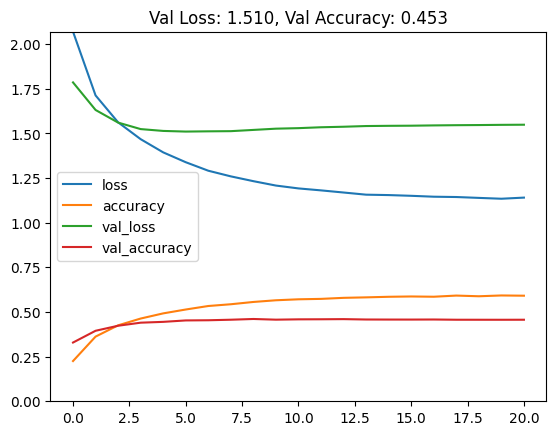

<Figure size 800x600 with 0 Axes>

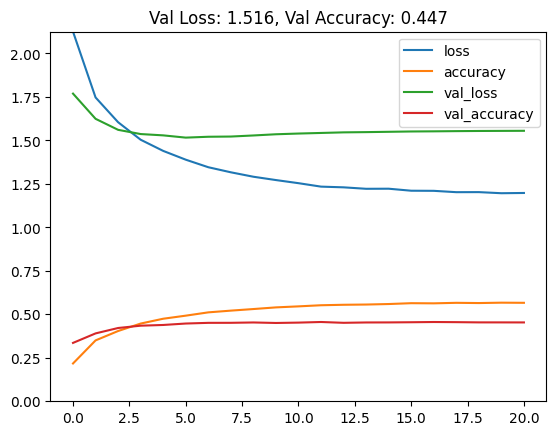

<Figure size 800x600 with 0 Axes>

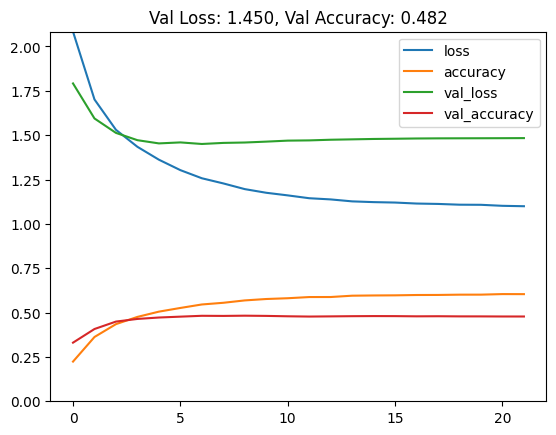

<Figure size 800x600 with 0 Axes>

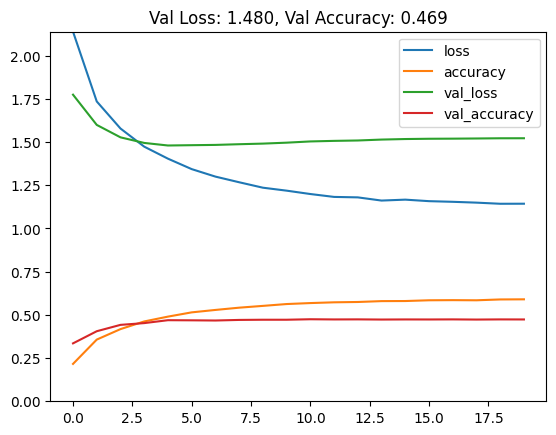

<Figure size 800x600 with 0 Axes>

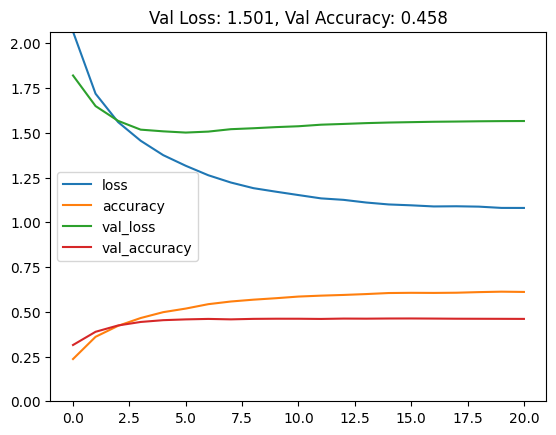

<Figure size 800x600 with 0 Axes>

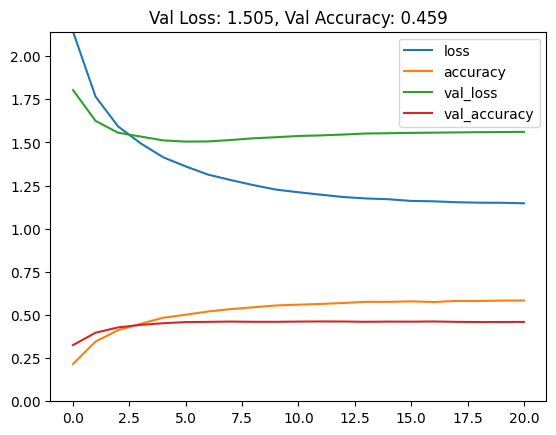

<Figure size 800x600 with 0 Axes>

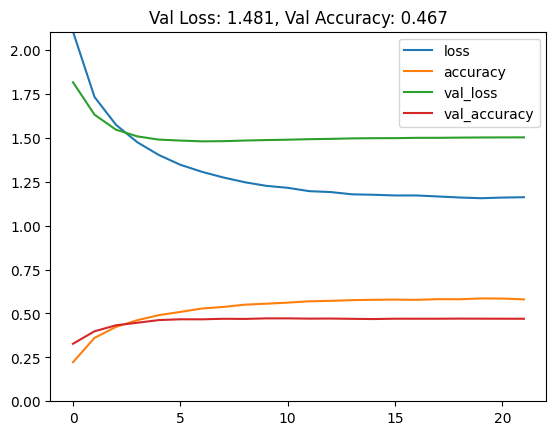

<Figure size 800x600 with 0 Axes>

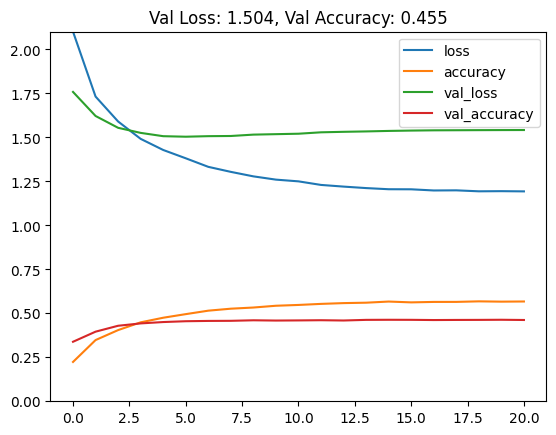

<Figure size 800x600 with 0 Axes>

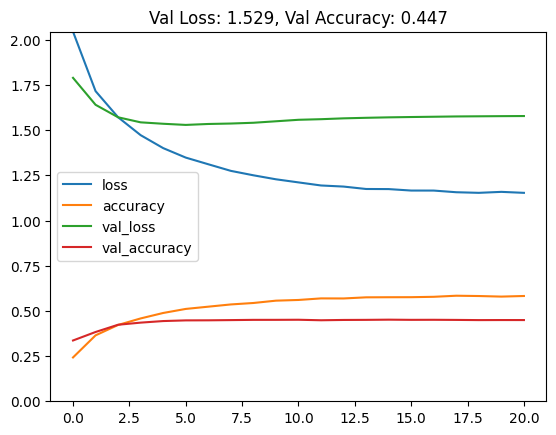

<Figure size 800x600 with 0 Axes>

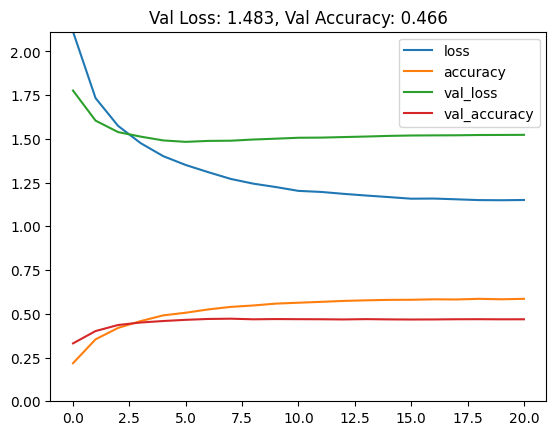

<Figure size 800x600 with 0 Axes>

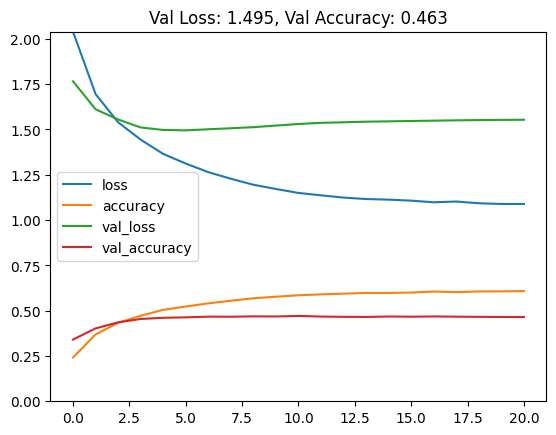

<Figure size 800x600 with 0 Axes>

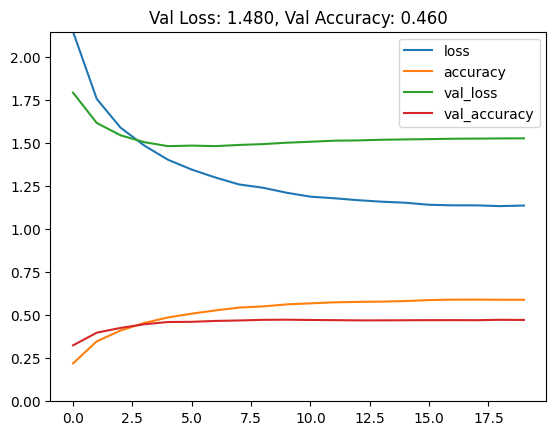

<Figure size 800x600 with 0 Axes>

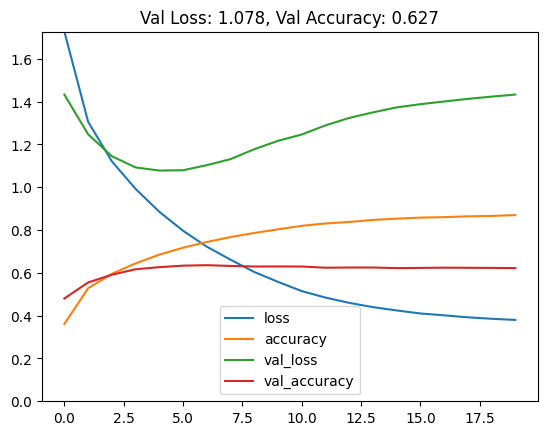

<Figure size 800x600 with 0 Axes>

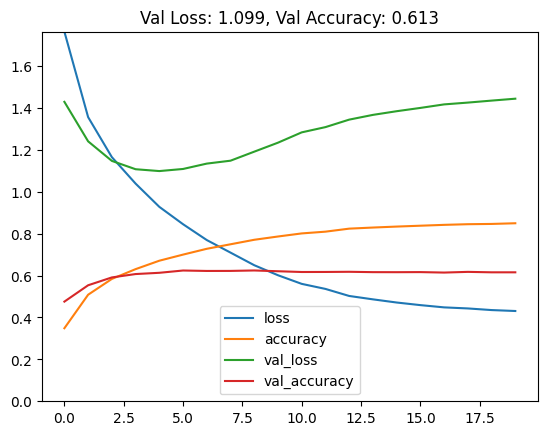

<Figure size 800x600 with 0 Axes>

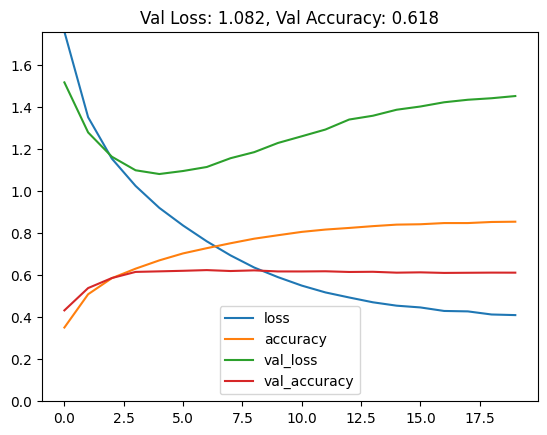

<Figure size 800x600 with 0 Axes>

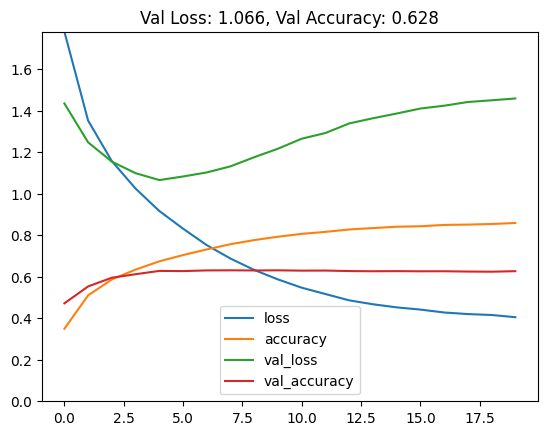

<Figure size 800x600 with 0 Axes>

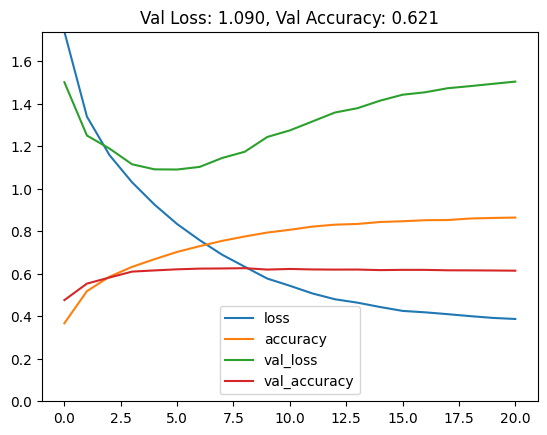

<Figure size 800x600 with 0 Axes>

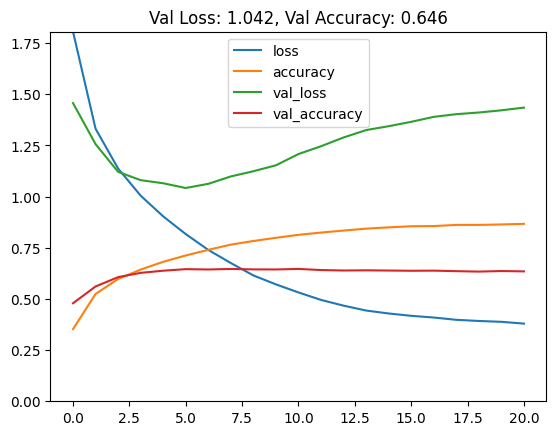

<Figure size 800x600 with 0 Axes>

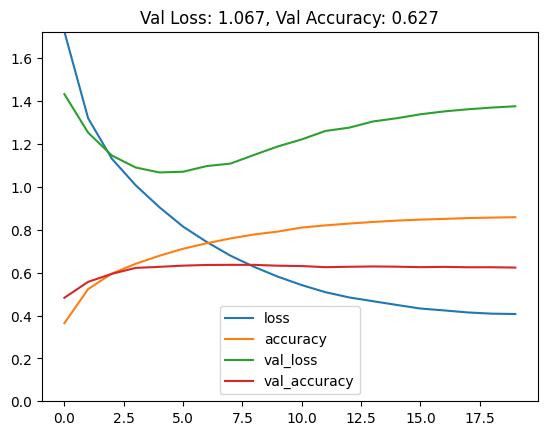

<Figure size 800x600 with 0 Axes>

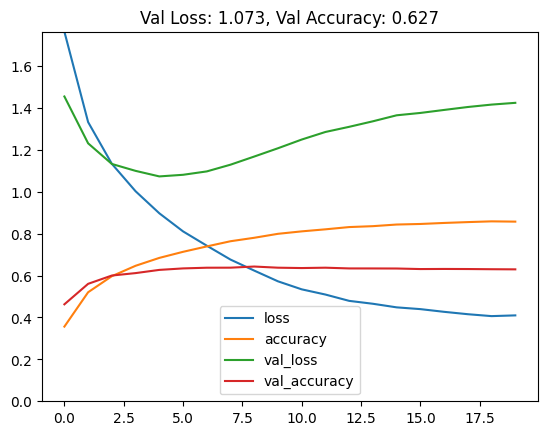

<Figure size 800x600 with 0 Axes>

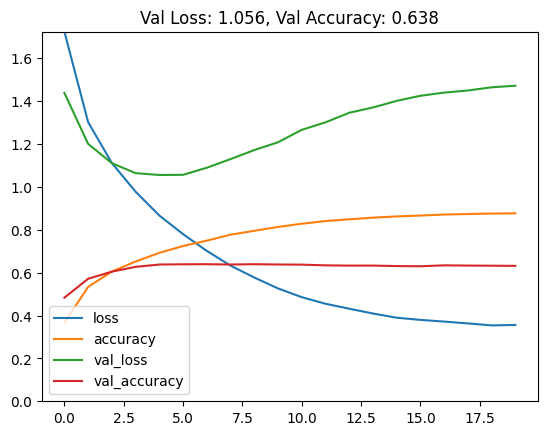

<Figure size 800x600 with 0 Axes>

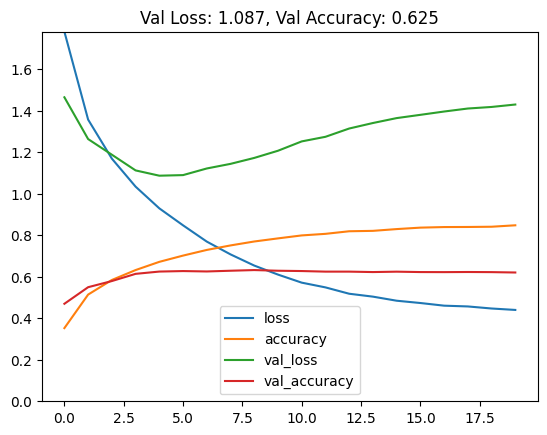

<Figure size 800x600 with 0 Axes>

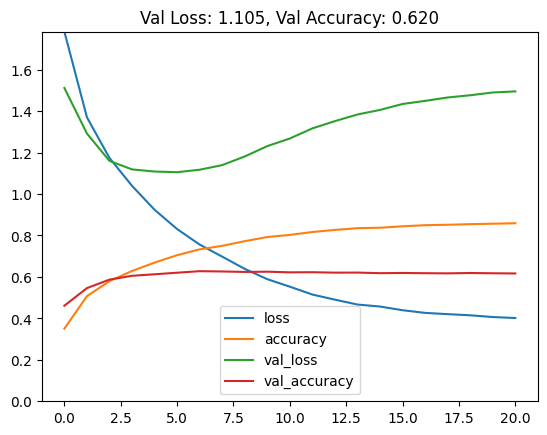

<Figure size 800x600 with 0 Axes>

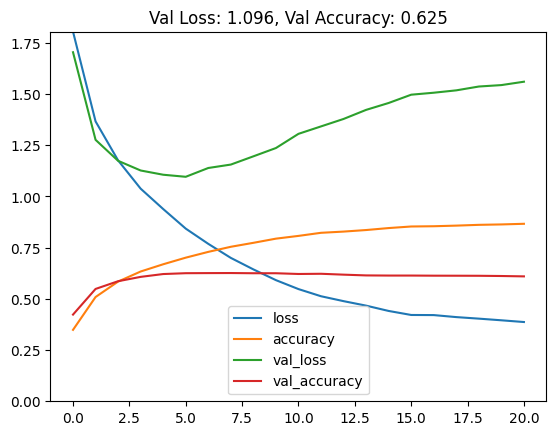

<Figure size 800x600 with 0 Axes>

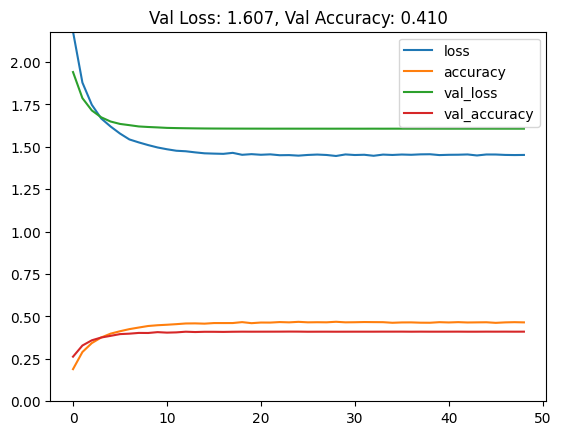

<Figure size 800x600 with 0 Axes>

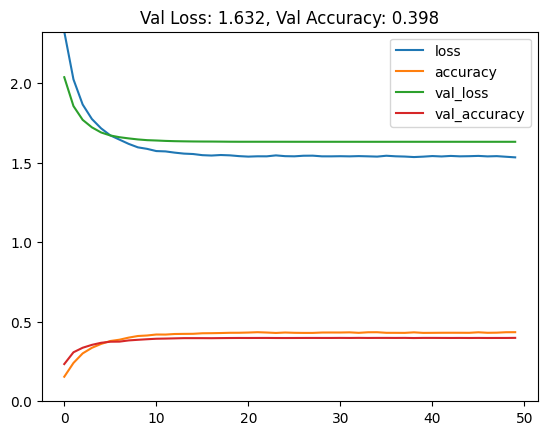

<Figure size 800x600 with 0 Axes>

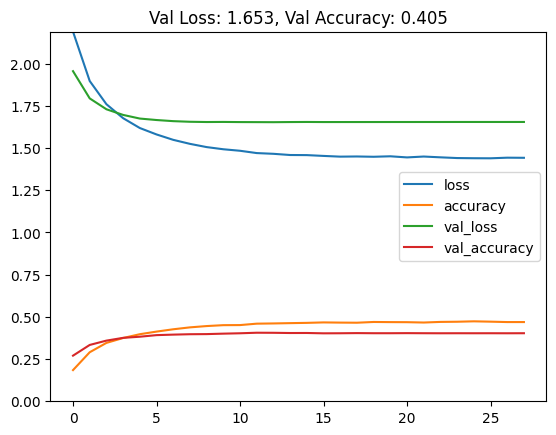

<Figure size 800x600 with 0 Axes>

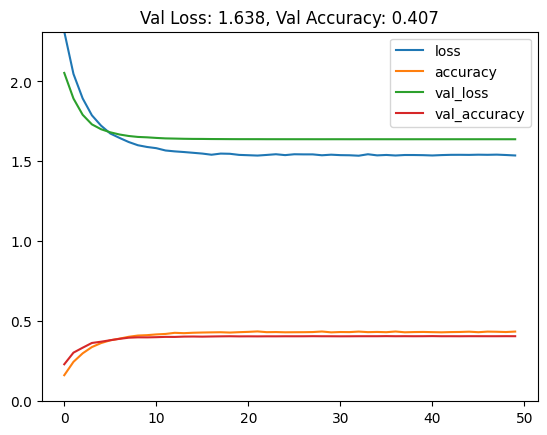

<Figure size 800x600 with 0 Axes>

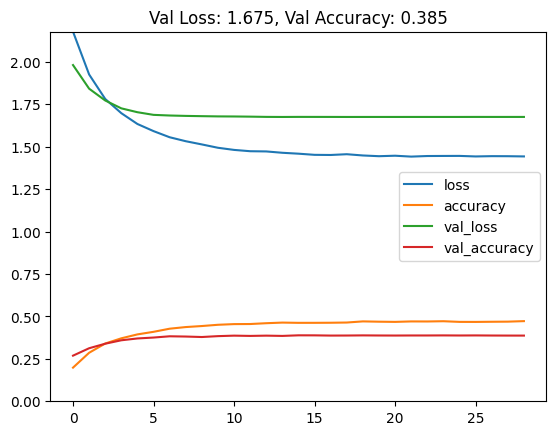

<Figure size 800x600 with 0 Axes>

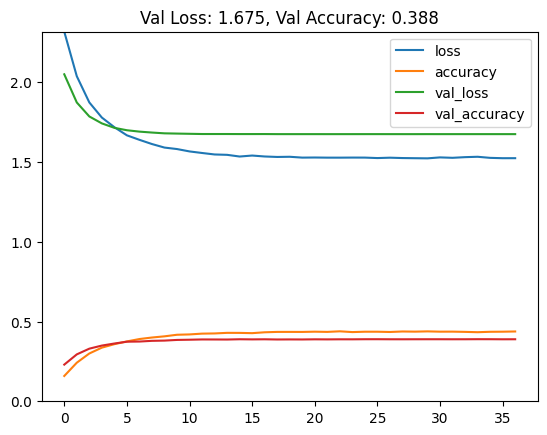

<Figure size 800x600 with 0 Axes>

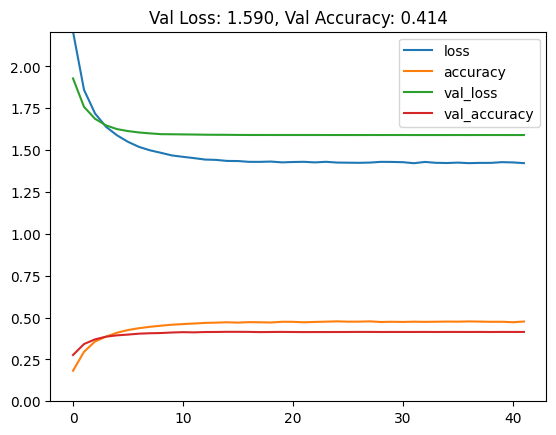

<Figure size 800x600 with 0 Axes>

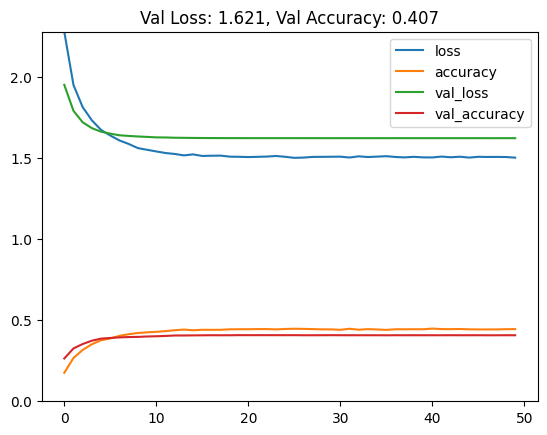

<Figure size 800x600 with 0 Axes>

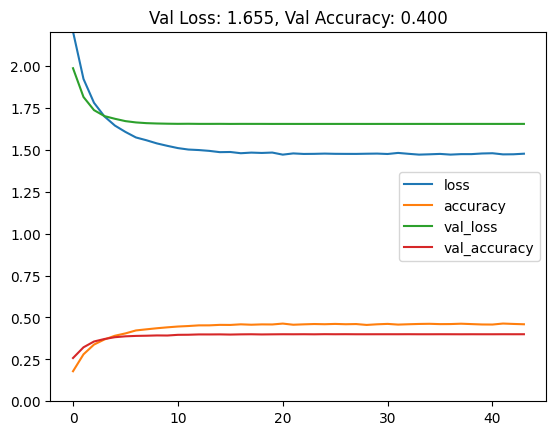

<Figure size 800x600 with 0 Axes>

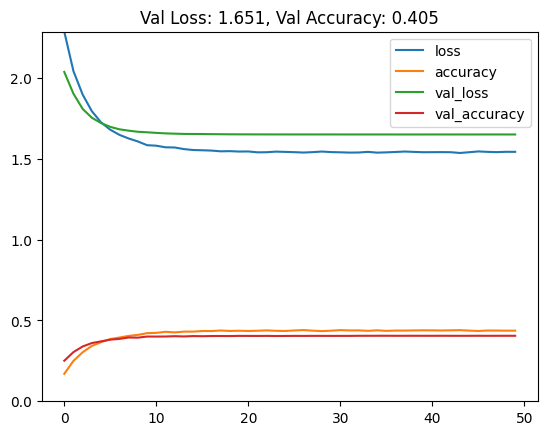

<Figure size 800x600 with 0 Axes>

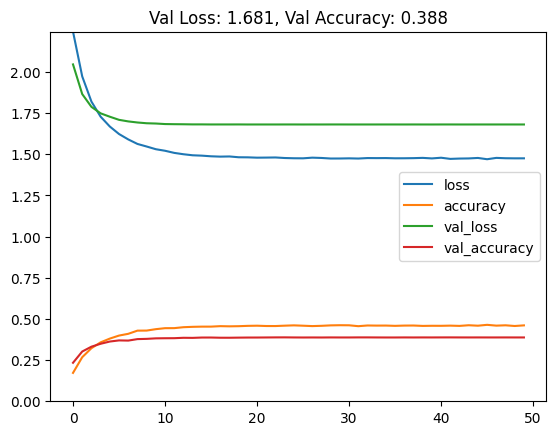

<Figure size 800x600 with 0 Axes>

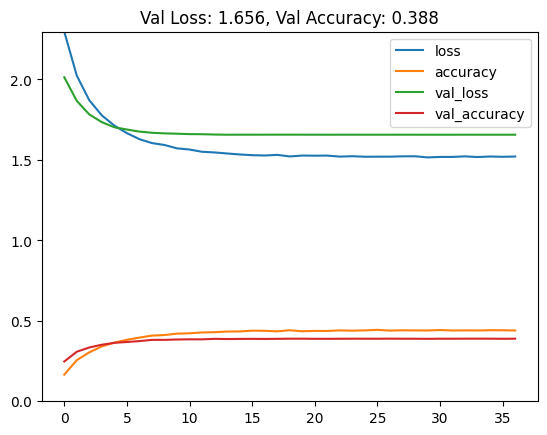

<Figure size 800x600 with 0 Axes>

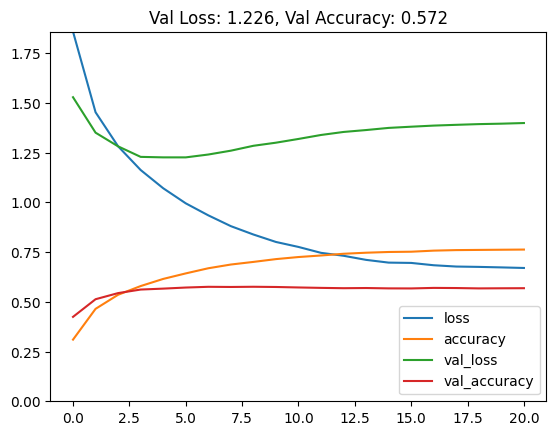

<Figure size 800x600 with 0 Axes>

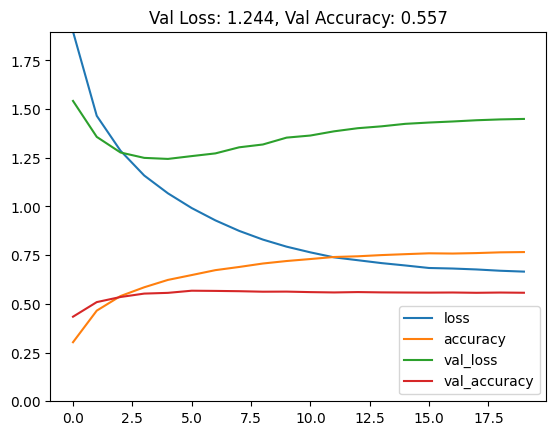

<Figure size 800x600 with 0 Axes>

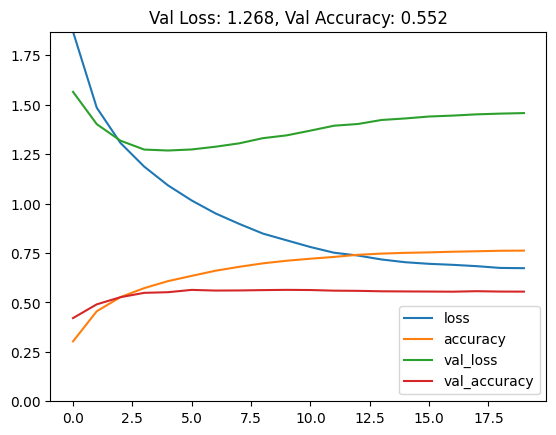

<Figure size 800x600 with 0 Axes>

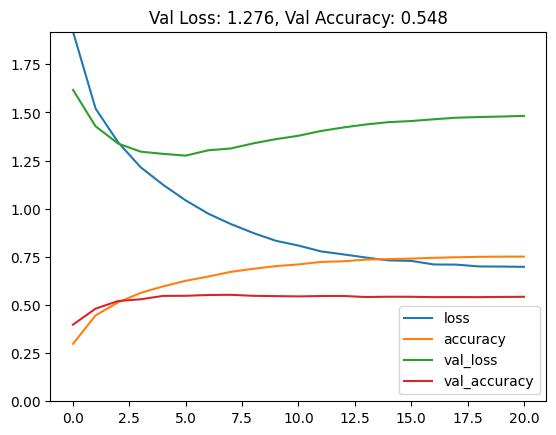

<Figure size 800x600 with 0 Axes>

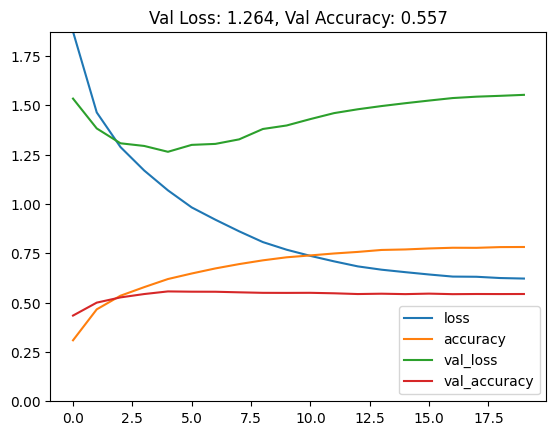

<Figure size 800x600 with 0 Axes>

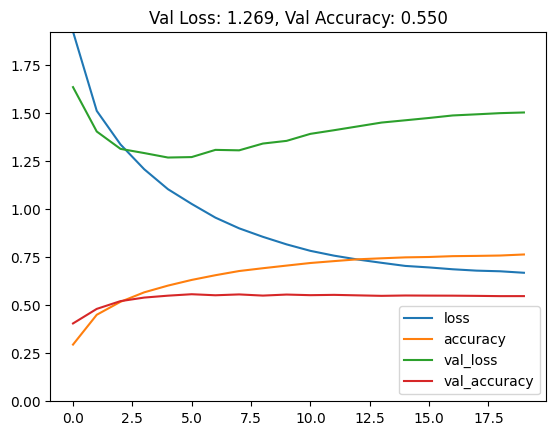

<Figure size 800x600 with 0 Axes>

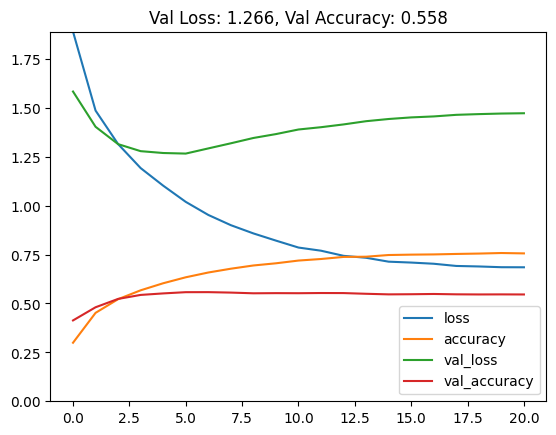

<Figure size 800x600 with 0 Axes>

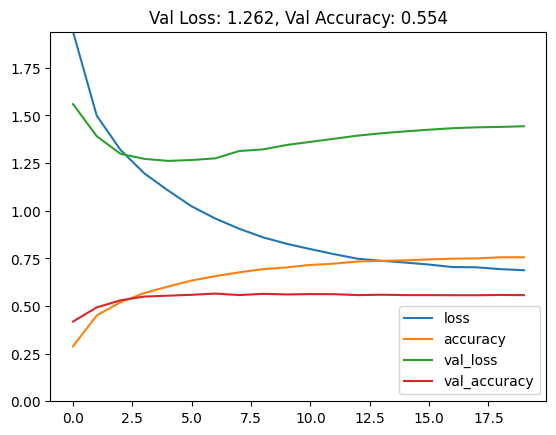

<Figure size 800x600 with 0 Axes>

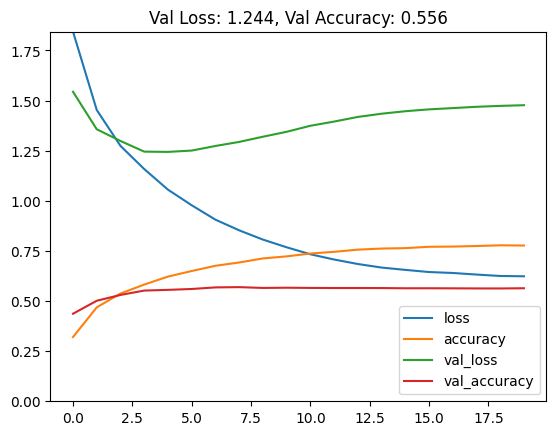

<Figure size 800x600 with 0 Axes>

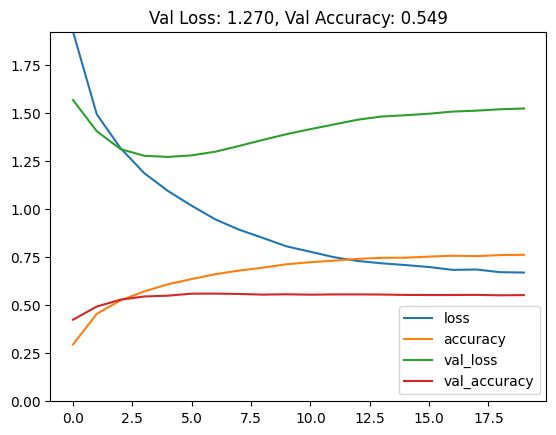

<Figure size 800x600 with 0 Axes>

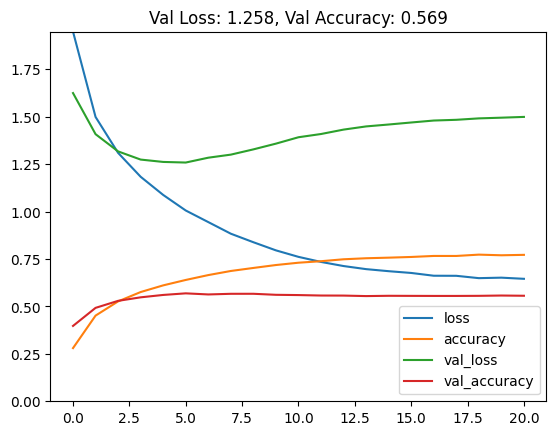

<Figure size 800x600 with 0 Axes>

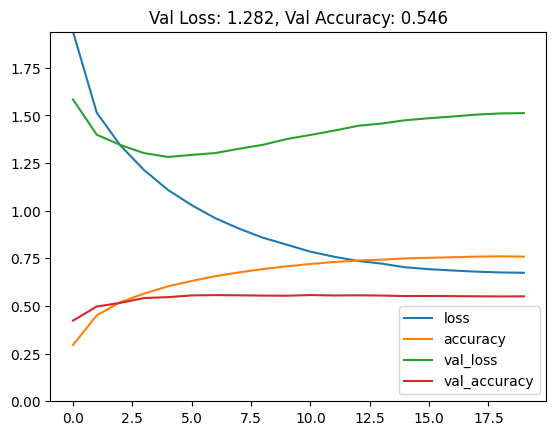

<Figure size 800x600 with 0 Axes>

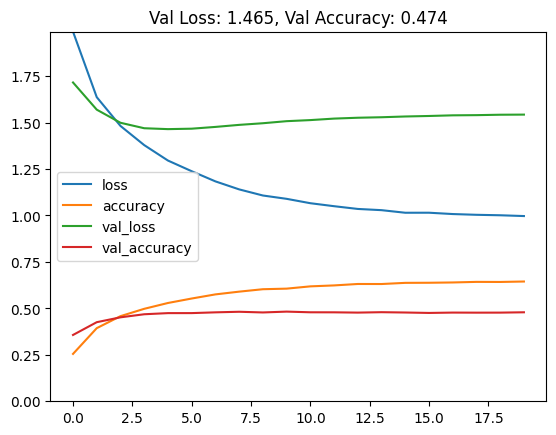

<Figure size 800x600 with 0 Axes>

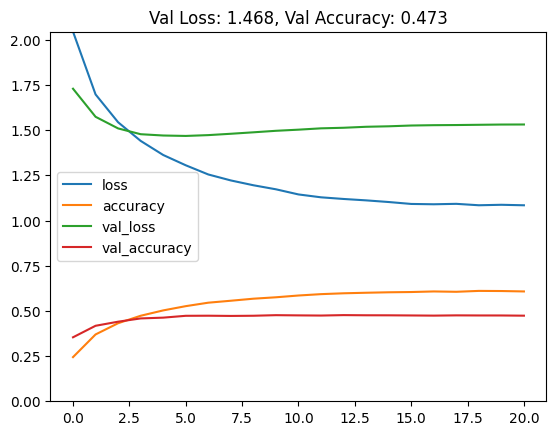

<Figure size 800x600 with 0 Axes>

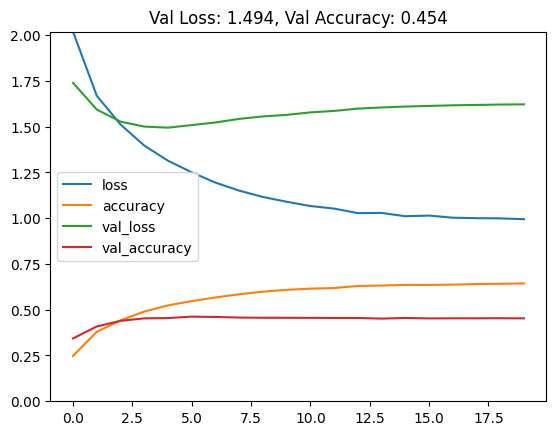

<Figure size 800x600 with 0 Axes>

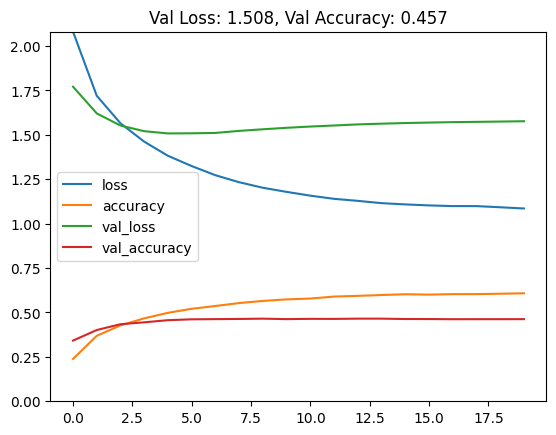

<Figure size 800x600 with 0 Axes>

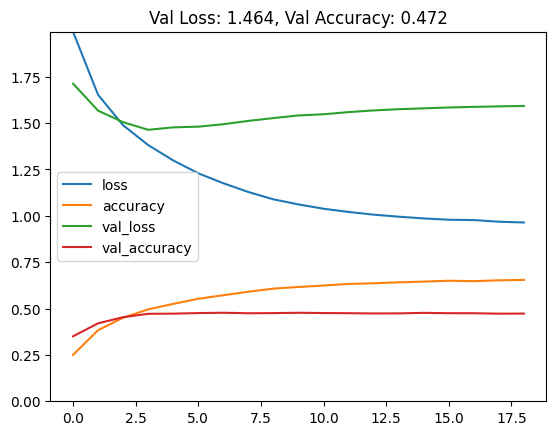

<Figure size 800x600 with 0 Axes>

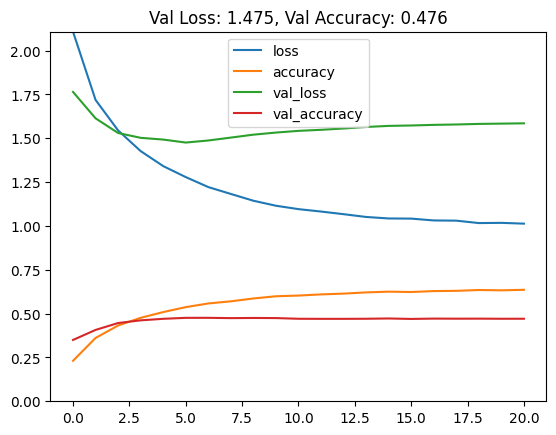

<Figure size 800x600 with 0 Axes>

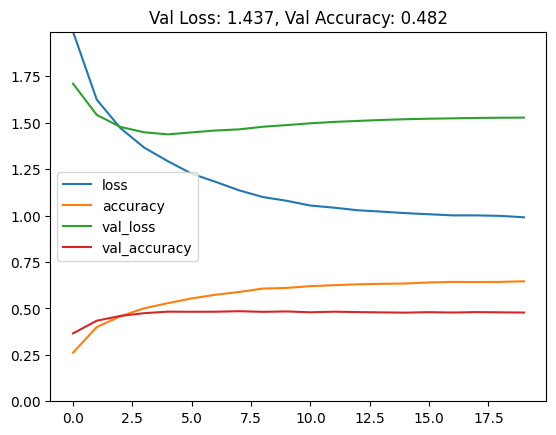

<Figure size 800x600 with 0 Axes>

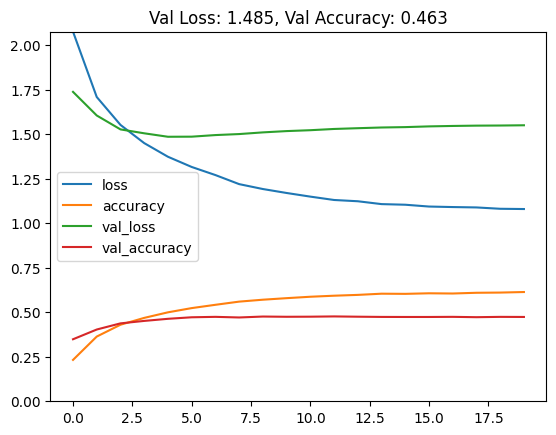

<Figure size 800x600 with 0 Axes>

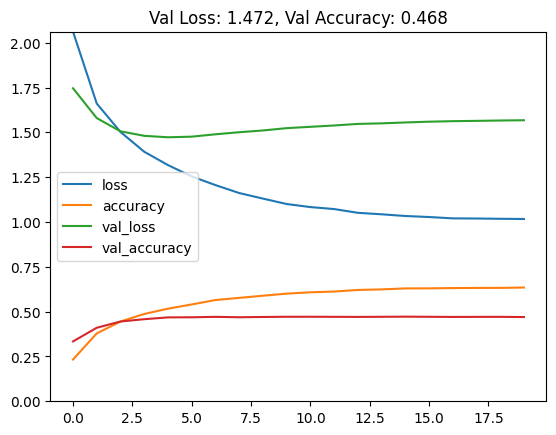

<Figure size 800x600 with 0 Axes>

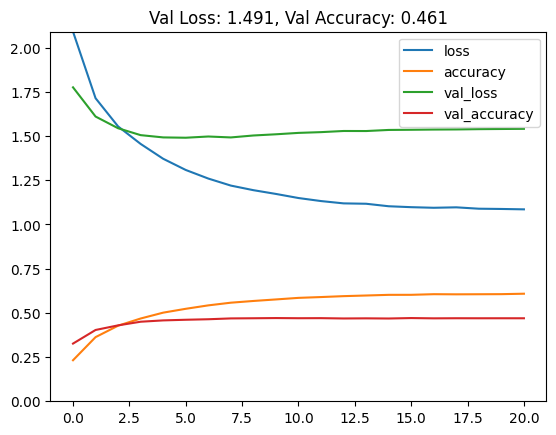

<Figure size 800x600 with 0 Axes>

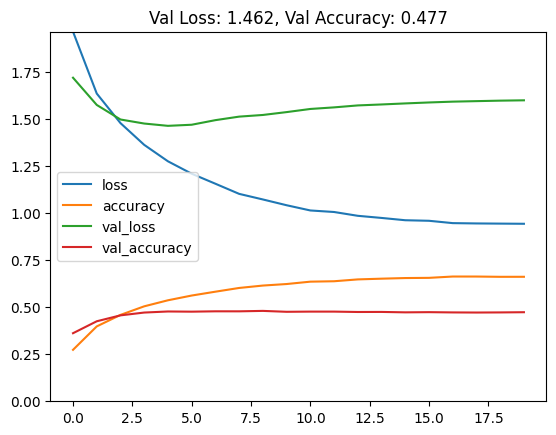

<Figure size 800x600 with 0 Axes>

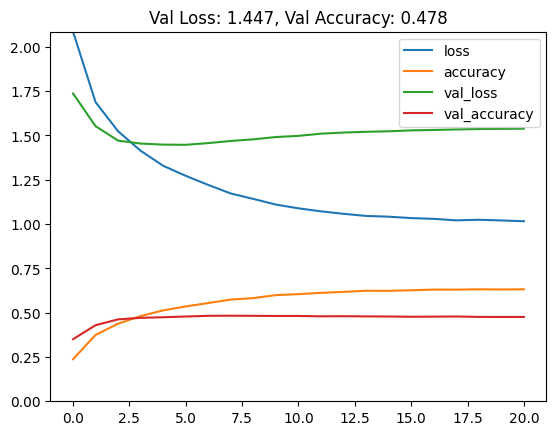

<Figure size 800x600 with 0 Axes>

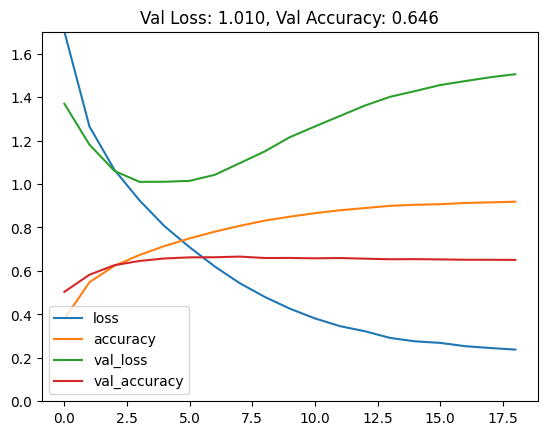

<Figure size 800x600 with 0 Axes>

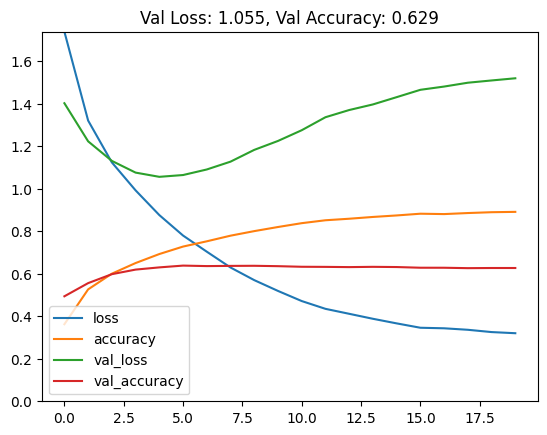

<Figure size 800x600 with 0 Axes>

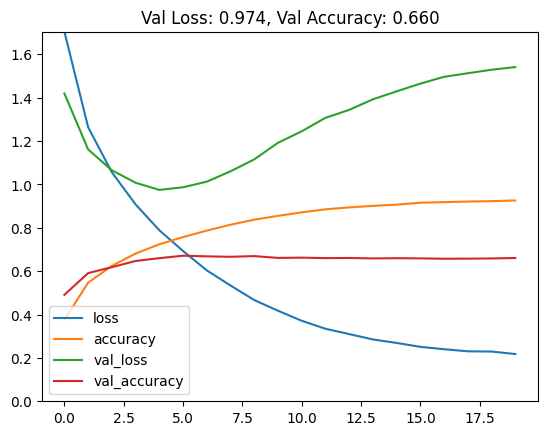

<Figure size 800x600 with 0 Axes>

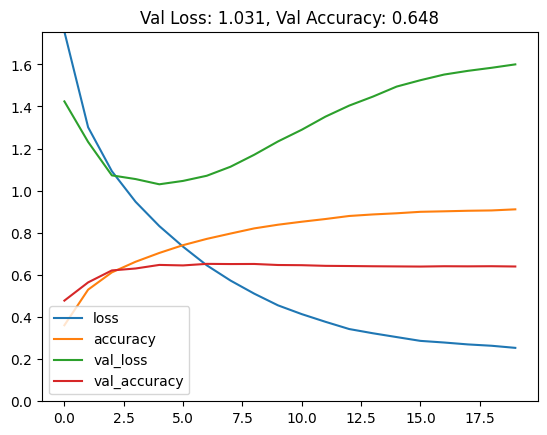

<Figure size 800x600 with 0 Axes>

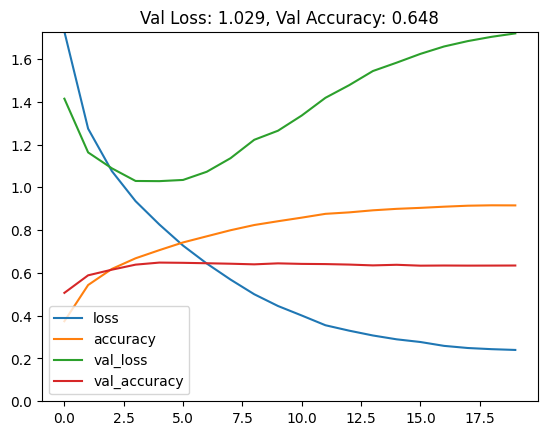

<Figure size 800x600 with 0 Axes>

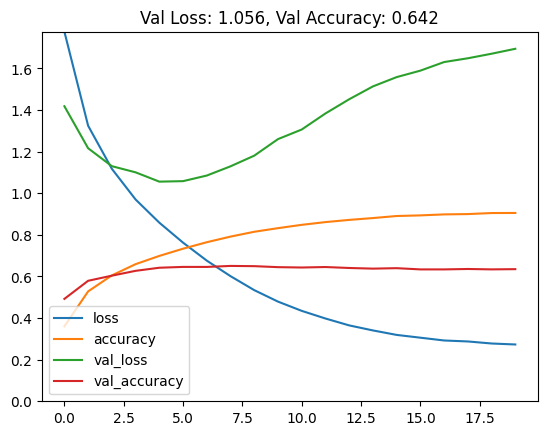

<Figure size 800x600 with 0 Axes>

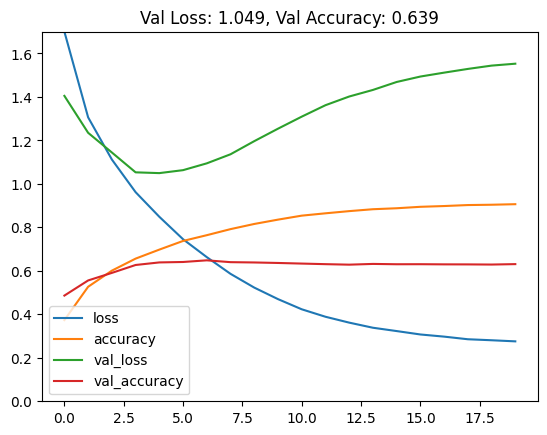

<Figure size 800x600 with 0 Axes>

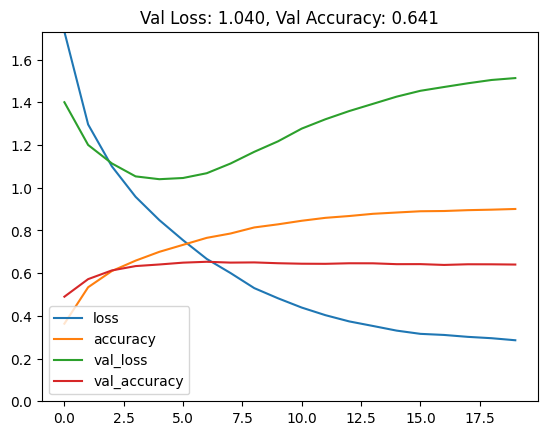

<Figure size 800x600 with 0 Axes>

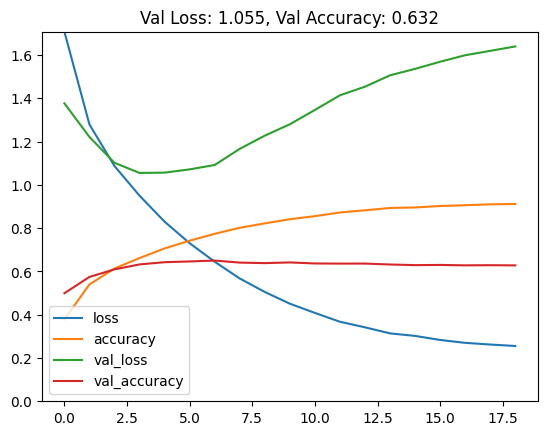

<Figure size 800x600 with 0 Axes>

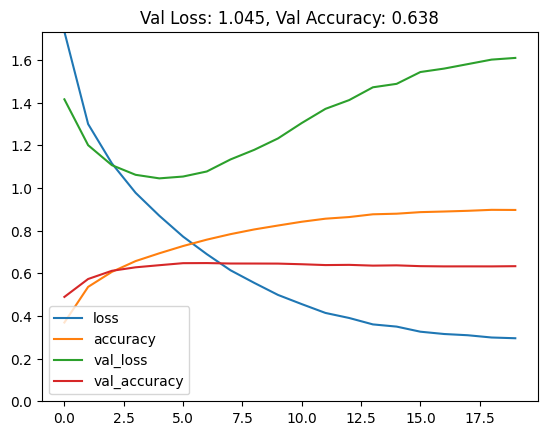

<Figure size 800x600 with 0 Axes>

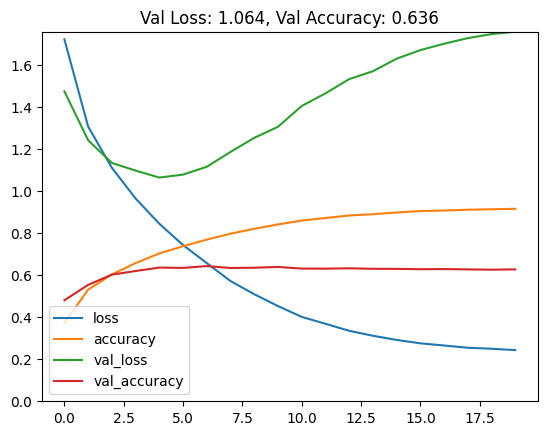

<Figure size 800x600 with 0 Axes>

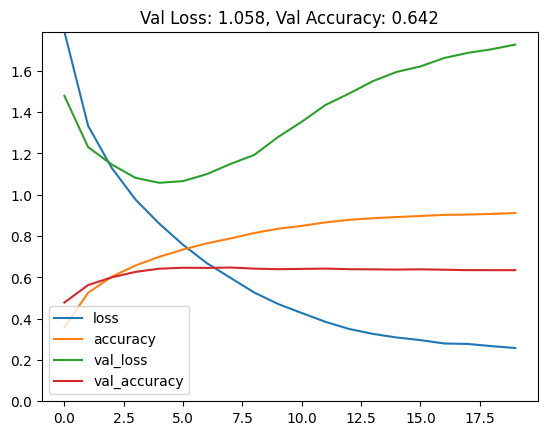

<Figure size 800x600 with 0 Axes>

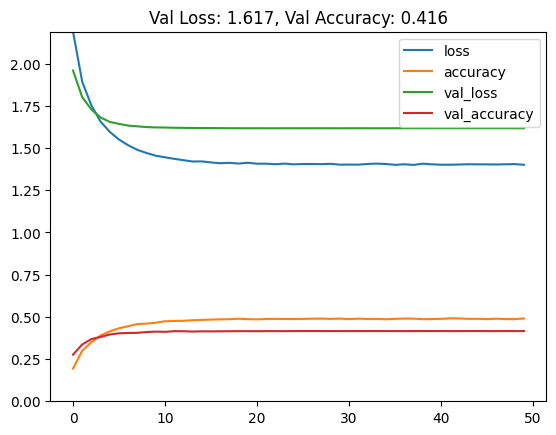

<Figure size 800x600 with 0 Axes>

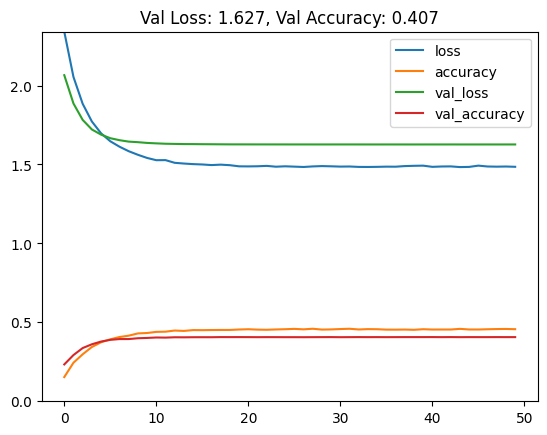

<Figure size 800x600 with 0 Axes>

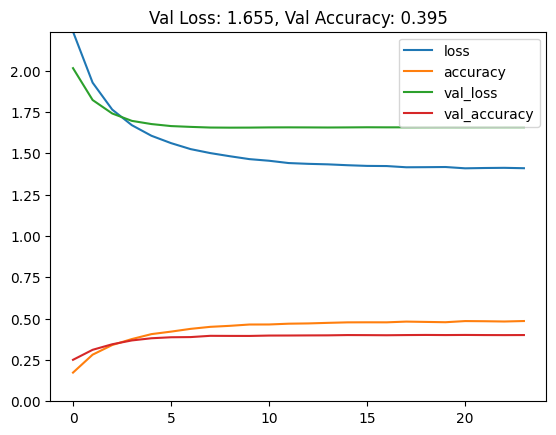

<Figure size 800x600 with 0 Axes>

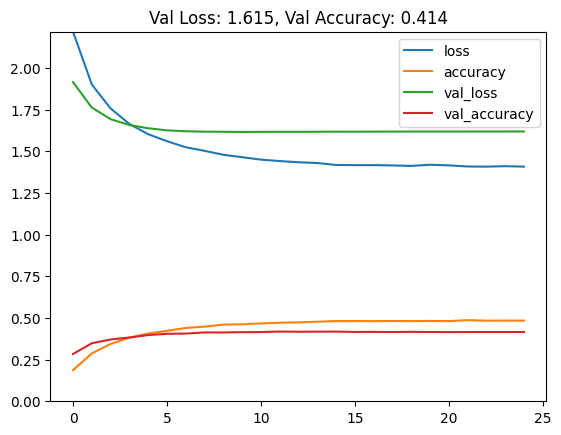

<Figure size 800x600 with 0 Axes>

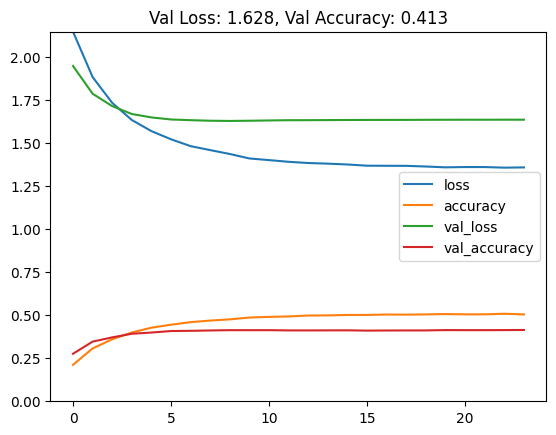

<Figure size 800x600 with 0 Axes>

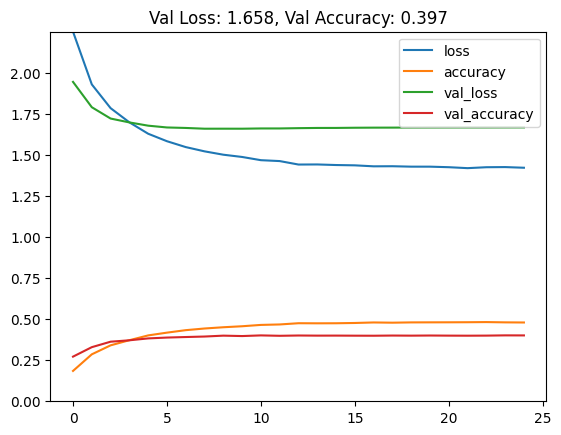

<Figure size 800x600 with 0 Axes>

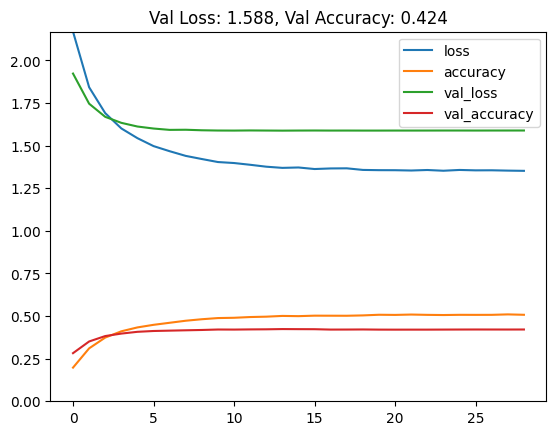

<Figure size 800x600 with 0 Axes>

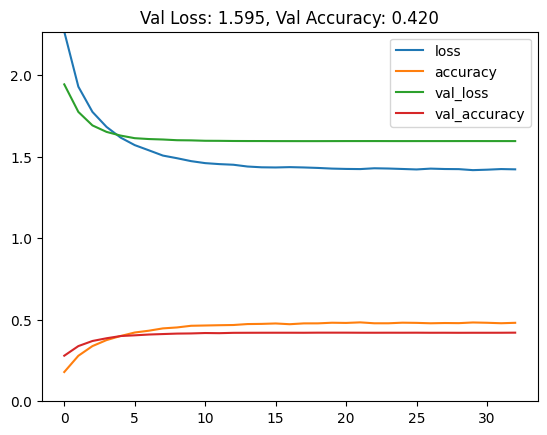

<Figure size 800x600 with 0 Axes>

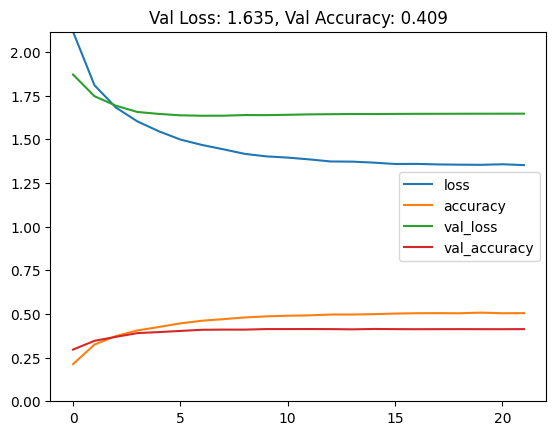

<Figure size 800x600 with 0 Axes>

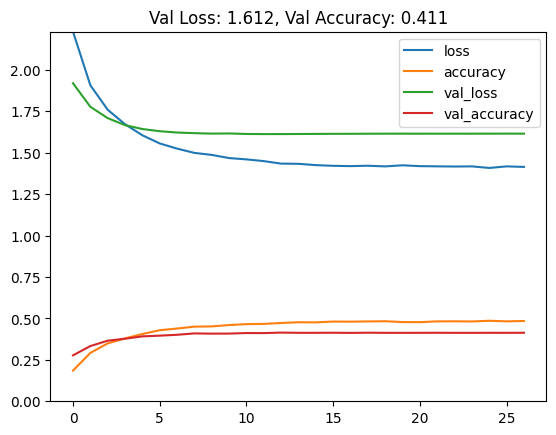

<Figure size 800x600 with 0 Axes>

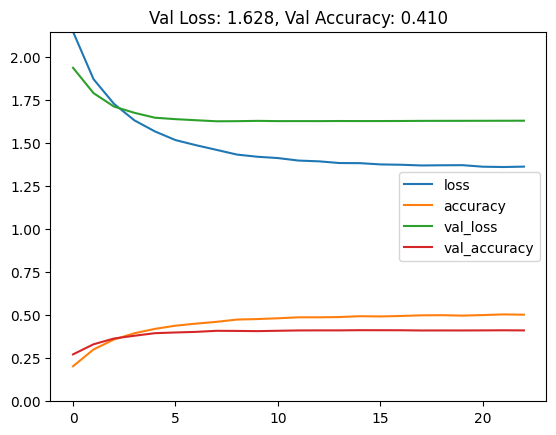

<Figure size 800x600 with 0 Axes>

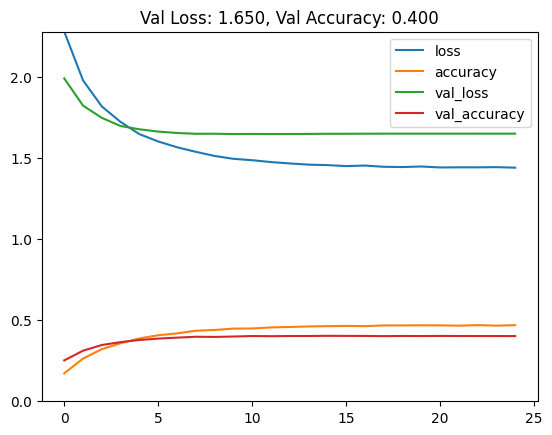

In [18]:
gc.collect()
# Grid Search for the best hyper para setting based on my experiments and the paper recommendations.
alpli = [0.8,0.9,1]
lrli = [0.0001,0.00005]
mli = [0.5,0.9]
wdli = [0.00001,0.00002]
fc_uli=[500,1000,2000]
fc_dli=[0.2,0.4]
# will get a multi dimensional array for validation loss of each trained model, each dimension
# maps to each hyper paramenter
val_loss_arr = np.zeros((len(alpli), len(lrli),len(mli),len(wdli),len(fc_uli),len(fc_dli)), dtype=np.float64)
# iterate each values to train the model
for (i, alp) in enumerate(alpli):
  for (j, lr) in enumerate(lrli):
    for (k, m) in enumerate(mli):
      for (l, wd) in enumerate(wdli):
        for (n, fc_u) in enumerate(fc_uli):
          for (o, fc_d) in enumerate(fc_dli):
            val_loss_arr[i,j,k,l,n,o] = hyp_tuning(alp,lr,m ,wd,fc_u,fc_d)
print(val_loss_arr)
with open('/content/drive/MyDrive/NarrativeTest_SharonXia/val_loss_arr_new.npy', 'wb') as f:
    np.save(f, val_loss_arr)

Have to stop the tuning due to time limitation of this task.

In [19]:
print(val_loss_arr)

[[[[[[1.51026046 1.51615322]
     [1.45049238 1.47962296]
     [1.50115168 1.50450766]]

    [[1.48055947 1.50403726]
     [1.52887785 1.4829427 ]
     [1.4948045  1.48043609]]]


   [[[1.07832444 1.09869158]
     [1.08153462 1.06579363]
     [1.09031904 1.04196548]]

    [[1.06716418 1.07347143]
     [1.05577302 1.08660913]
     [1.10533106 1.0956471 ]]]]



  [[[[1.60659373 1.6315974 ]
     [1.65270448 1.63806832]
     [1.67510641 1.67512846]]

    [[1.59034801 1.62114012]
     [1.65462387 1.65082085]
     [1.68071759 1.65632927]]]


   [[[1.22599089 1.24416876]
     [1.26812983 1.27574205]
     [1.26396632 1.26896417]]

    [[1.26620615 1.26159322]
     [1.24407363 1.27010357]
     [1.25840271 1.28179526]]]]]




 [[[[[1.46455383 1.46800721]
     [1.4942255  1.50820541]
     [1.46395528 1.47545743]]

    [[1.43679166 1.48474991]
     [1.47237837 1.49071252]
     [1.46249688 1.44692886]]]


   [[[1.01010942 1.05525899]
     [0.97448945 1.0305028 ]
     [1.02885187 1.05576754]]

    [

In [24]:
min_non_zero_index = np.unravel_index(np.argmin(val_loss_arr[np.nonzero(val_loss_arr)]),val_loss_arr.shape)

print(val_loss_arr[min_non_zero_index])
print(min_non_zero_index)

ind = min_non_zero_index
alp = alpli[ind[0]]
lr= lrli[ind[1]]
m = mli[ind[2]]
wd = wdli[ind[3]]
fc_u = fc_uli[ind[4]]
fc_d = fc_dli[ind[5]]
print(alp, lr,m,wd,fc_u,fc_d)

0.9744894504547119
(1, 0, 1, 0, 1, 0)
0.9 0.0001 0.9 1e-05 1000 0.2


The experiments we have not done is alpha  = 1 or or larger. It might increase the model accuracy with increase the model complexity which needs to be tested. But it will increase the model size laterally. Let's have a look at training graph.

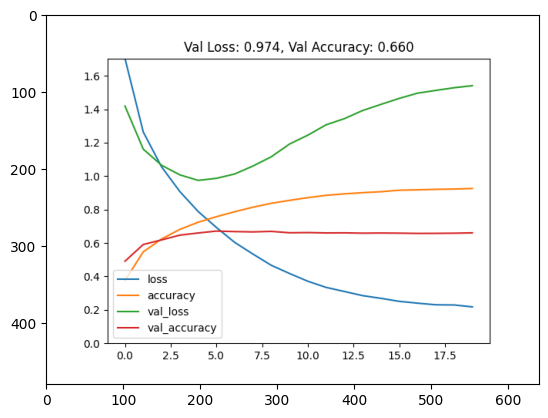

In [25]:
parent_dir = '/content/drive/MyDrive/NarrativeTest_SharonXia/new_modelV2_alpha_%.3f_lr_%.9f_m_%.2f_wd_%.7f_fcu_%.1f_fcd_%.2f'%(alp,lr,m,wd,fc_u,fc_d)
import matplotlib.image as mpimg
img = mpimg.imread(parent_dir+'.png')
plt.imshow(img)
plt.show()

There is an overfitting problem with this model. The early stopping has helped regularization. We could increase the weight decay, dropout rate to further regularize the model. We could also further reduce the learning rate during training to approach the minimum point better.

In [27]:
model_path = os.path.join(parent_dir,os.listdir(parent_dir)[-1])
print(model_path)
trained_model = tf.keras.models.load_model(model_path)
trained_model.summary()

/content/drive/MyDrive/NarrativeTest_SharonXia/new_modelV2_alpha_0.900_lr_0.000100000_m_0.90_wd_0.0000100_fcu_1000.0_fcd_0.20/model.h5
Model: "model_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_135 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_67 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 tf.math.subtract_67 (TFOpL  (None, 32, 32, 3)         0         
 ambda)                                                          
                                                                 
 model_134 (Functional)      (None, 2, 2, 88)          469056    
                                                                 
 conv2d_67 (Conv2D)          (None, 2, 2, 1000)       

In [28]:
# Re-evaluate the model with test dataset, preprocess is already embedded in the model
loss, accuracy  = trained_model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 1.03
Test accuracy: 0.653


In [32]:
def model_evaluate(model_path):
  # import data
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  assert x_train.shape == (50000, 32, 32, 3)
  assert x_test.shape == (10000, 32, 32, 3)
  assert y_train.shape == (50000, 1)
  assert y_test.shape == (10000, 1)
  # load the best model
  trained_model = tf.keras.models.load_model(model_path)
  trained_model.summary()
  # model evaluation
  # get the prediction labels by finding the position for the biggest probability
  start_time= time.time()
  y_pred_prob = trained_model.predict(x_test)
  y_pred = np.argmax(y_pred_prob,axis =1)
  stop_time=time.time()
  duration =stop_time - start_time
  msec_per = duration*(10**6)/len(y_test)
  print('The inference time of the model in milliseconds per image on GPU is %.9f'%(msec_per))
  classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  print(classification_report(y_test, y_pred,target_names=classes))
  # confusion matrix to display
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= classes)
  disp.plot()

Model: "model_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_135 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_67 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 tf.math.subtract_67 (TFOpL  (None, 32, 32, 3)         0         
 ambda)                                                          
                                                                 
 model_134 (Functional)      (None, 2, 2, 88)          469056    
                                                                 
 conv2d_67 (Conv2D)          (None, 2, 2, 1000)        89000     
                                                                 
 batch_normalization_67 (Ba  (None, 2, 2, 1000)        40

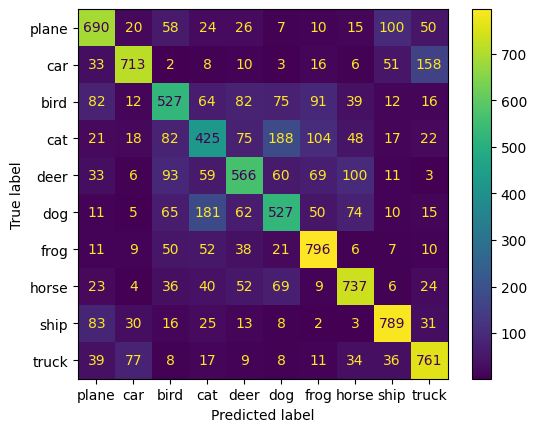

In [33]:
model_evaluate(model_path)